# Figure 2.b-c : Showing qualitative WNet3D performance on additional datasets

- Show that self-supervised model can perform well on additional datasets, without requiring any additional training.

In [2]:
import numpy as np
from tifffile import imread, imwrite
import sys
import numpy as np

import pyclesperanto_prototype as cle
from stardist.matching import matching_dataset
sys.path.append("../..")

from utils import *
from plots import *
print("Used GPU: ", cle.get_device())
show_params()
#################
SAVE_PLOTS_AS_PNG = False
SAVE_PLOTS_AS_SVG = True

Used GPU:  <NVIDIA GeForce RTX 4070 Ti on Platform: NVIDIA CUDA (1 refs)>
Plot parameters (set in plots.py) : 
- COLORMAP : ████████
- DPI : 200
- Data path : C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK
- Font size : 20
- Title font size : 25.0
- Label font size : 20.0


In [3]:
%load_ext autoreload
%autoreload 2

## Data

In [4]:
data_path = DATA_PATH / "RESULTS/WNET OTHERS/"

# list all folders in the data path
folders = [x for x in data_path.iterdir() if x.is_dir()]
folders

[WindowsPath('C:/Users/Cyril/Desktop/Code/CELLSEG_BENCHMARK/RESULTS/WNET OTHERS/Mouse-Skull-Nuclei-CBG'),
 WindowsPath('C:/Users/Cyril/Desktop/Code/CELLSEG_BENCHMARK/RESULTS/WNET OTHERS/Platynereis-ISH-Nuclei-CBG'),
 WindowsPath('C:/Users/Cyril/Desktop/Code/CELLSEG_BENCHMARK/RESULTS/WNET OTHERS/Platynereis-Nuclei-CBG'),
 WindowsPath('C:/Users/Cyril/Desktop/Code/CELLSEG_BENCHMARK/RESULTS/WNET OTHERS/processed_instance_labels'),
 WindowsPath('C:/Users/Cyril/Desktop/Code/CELLSEG_BENCHMARK/RESULTS/WNET OTHERS/Seb cFOS')]

In [5]:
def get_predictions(path):
    return [imread(f) for f in path.glob("*.tif")]
#################
gt_folder = "labels"
mouse_skull_gt = get_predictions(folders[0] / gt_folder)[0]
platynereis_ISH_gt = get_predictions(folders[1] / gt_folder)[0]
platynereis_gt = get_predictions(folders[2] / gt_folder)[0]

In [6]:
prediction_folder = "pred"
mouse_skull_pred = get_predictions(folders[0] / prediction_folder)[0]
platynereis_ISH_pred = get_predictions(folders[1] / prediction_folder)[0]
platynereis_pred = get_predictions(folders[2] / prediction_folder)[0]

In [7]:
# get second channel of predictions
mouse_skull_pred = mouse_skull_pred[1]
platynereis_ISH_pred = platynereis_ISH_pred[1]
platynereis_pred = platynereis_pred[1]

In [8]:
# get validation set to estimate thresholds
mouse_skull_val = imread(folders[0] / "TEST/X2_left_WNet3D_pred_1.tif")[1] # take channel 1 of WNet prediction (0 is background)
mouse_skull_val_gt = imread(folders[0] / "TEST/Y2_left.tif")
###
platynereis_ISH_val = imread(folders[1] / "TEST/downsampled_cropped_X02_train_WNet3D_pred.tif")[1]
platynereis_ISH_val_gt = imread(folders[1] / "TEST/downsampled_cropped_Y02_train.tif")
###
platynereis_val = imread(folders[2] / "TEST/downsampled_cropped_dataset_hdf5_150_0_WNet3D_pred_1.tif")[1]
platynereis_val_gt = imread(folders[2] / "TEST/downsampled_cropped_mask_dataset_hdf5_150_0.tif")

## Computations

### Threshold predictions

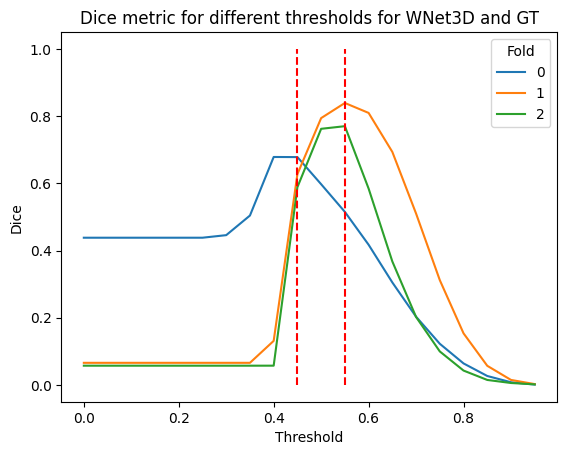

In [9]:
GT_labels_val = [mouse_skull_val_gt, platynereis_ISH_val_gt, platynereis_val_gt]
predictions_val = [mouse_skull_val, platynereis_ISH_val, platynereis_val]

thresh = np.arange(0, 1, 0.05)
rows = []
for t in thresh:
    for i, (gt, pred) in enumerate(zip(GT_labels_val, predictions_val)):
        dices_row = {"Threshold": t, "Fold": i, "Dice": dice_coeff(
            np.where(gt > 0, 1, 0),
            np.where(pred > t, 1, 0)
            )}
        rows.append(dices_row)
        
dices_df = pd.DataFrame(rows)

sns.lineplot(data=dices_df, x="Threshold", y="Dice", hue="Fold", palette="tab10")
plt.title("Dice metric for different thresholds for WNet3D and GT")
plt.vlines([0.45, 0.55], 0, 1, colors="red", linestyles="dashed")
plt.show()

In [10]:
dices_df.groupby("Threshold").mean().sort_values("Dice", ascending=False).head(5)

,Fold,Dice
Threshold,,
0.50,1.0,0.717895
0.55,1.0,0.708049
0.45,1.0,0.631312
0.60,1.0,0.603701
0.65,1.0,0.455269


In [11]:
predictions = [mouse_skull_pred, platynereis_ISH_pred, platynereis_pred]
GT_labels = [mouse_skull_gt, platynereis_ISH_gt, platynereis_gt]

In [12]:
predictions_thresholded = []
thresholds = [0.45, 0.55, 0.55]
for i, pred in enumerate(predictions):
    predictions_thresholded.append(np.where(pred > thresholds[i], 1, 0))

In [13]:
mouse_skull_instance = np.array(
    cle.voronoi_otsu_labeling(predictions_thresholded[0], outline_sigma=1, spot_sigma=15)
)
platynereis_ISH_instance = np.array(
    cle.voronoi_otsu_labeling(predictions_thresholded[1], outline_sigma=0.5, spot_sigma=2)
)
platynereis_instance = np.array(
    cle.voronoi_otsu_labeling(predictions_thresholded[2], outline_sigma=0.5, spot_sigma=2.75)
)

### Additional mouse skull postprocessing

In [14]:
mouse_skull_instance = np.array(cle.closing_labels(mouse_skull_instance, radius=8))

In [15]:
def remap_image(image, new_min=1, new_max=100):
    min_val = image.min()
    max_val = image.max()
    return (image - min_val) / (max_val - min_val) * (new_max - new_min) + new_min

In [16]:
mouse_skull_remap = remap_image(mouse_skull_pred)
mouse_skull_instance = cle.merge_labels_with_border_intensity_within_range(
    image=mouse_skull_remap,
    labels=mouse_skull_instance.astype(np.int32), 
    minimum_intensity=35, 
    maximum_intensity=100
    )
mouse_skull_instance = np.array(mouse_skull_instance)

_generate_touch_mean_intensity_matrix.py (30): generate_touch_mean_intensity_matrix is supposed to work with images of integer type only.
Loss of information is possible when passing non-integer images.
_opencl_execute.py (281): overflow encountered in cast


In [17]:
# import napari
# viewer = napari.Viewer()
# viewer.add_image(predictions_thresholded[0], colormap="turbo")
# viewer.add_labels(mouse_skull_instance)
# viewer.add_labels(mouse_skull_instance, name="mouse_skull_instance_closed")
# viewer.add_image(mouse_skull_remap, name="mouse_skull_pred_remap", colormap="turbo")
# viewer.add_labels(mouse_skull_instance, name="mouse_skull_instance_closed_merged")

In [18]:
# Show the predictions and the instance segmentation
# import napari
# viewer = napari.Viewer()

# viewer.add_image(predictions_thresholded[0], name="mouse_skull_pred", colormap="turbo")
# viewer.add_labels(mouse_skull_instance, name="mouse_skull_instance")
# viewer.add_image(predictions_thresholded[1], name="platynereis_ISH_pred", colormap="turbo")
# viewer.add_labels(platynereis_ISH_instance, name="platynereis_ISH_instance")
# viewer.add_image(predictions_thresholded[2], name="platynereis_pred", colormap="turbo")
# viewer.add_labels(platynereis_instance, name="platynereis_instance")

## Plots

In [19]:
predictions = [
    mouse_skull_instance,
    platynereis_ISH_instance,
    platynereis_instance,
   ]
GT_labels = [
    mouse_skull_gt,
    platynereis_ISH_gt,
    platynereis_gt,
    ]
names = [
    "Mouse skull",
    "Platynereis ISH",
    "Platynereis",
    ]


In [20]:
# save instance labels
for pred, name in zip(predictions, names):
    save_path = data_path / "processed_instance_labels"
    save_path.mkdir(exist_ok=True)
    imwrite(save_path / f"{name}.tif", pred.astype(np.uint32))

Validating on Mouse skull
********************
Validating on Platynereis ISH
********************
Validating on Platynereis
********************


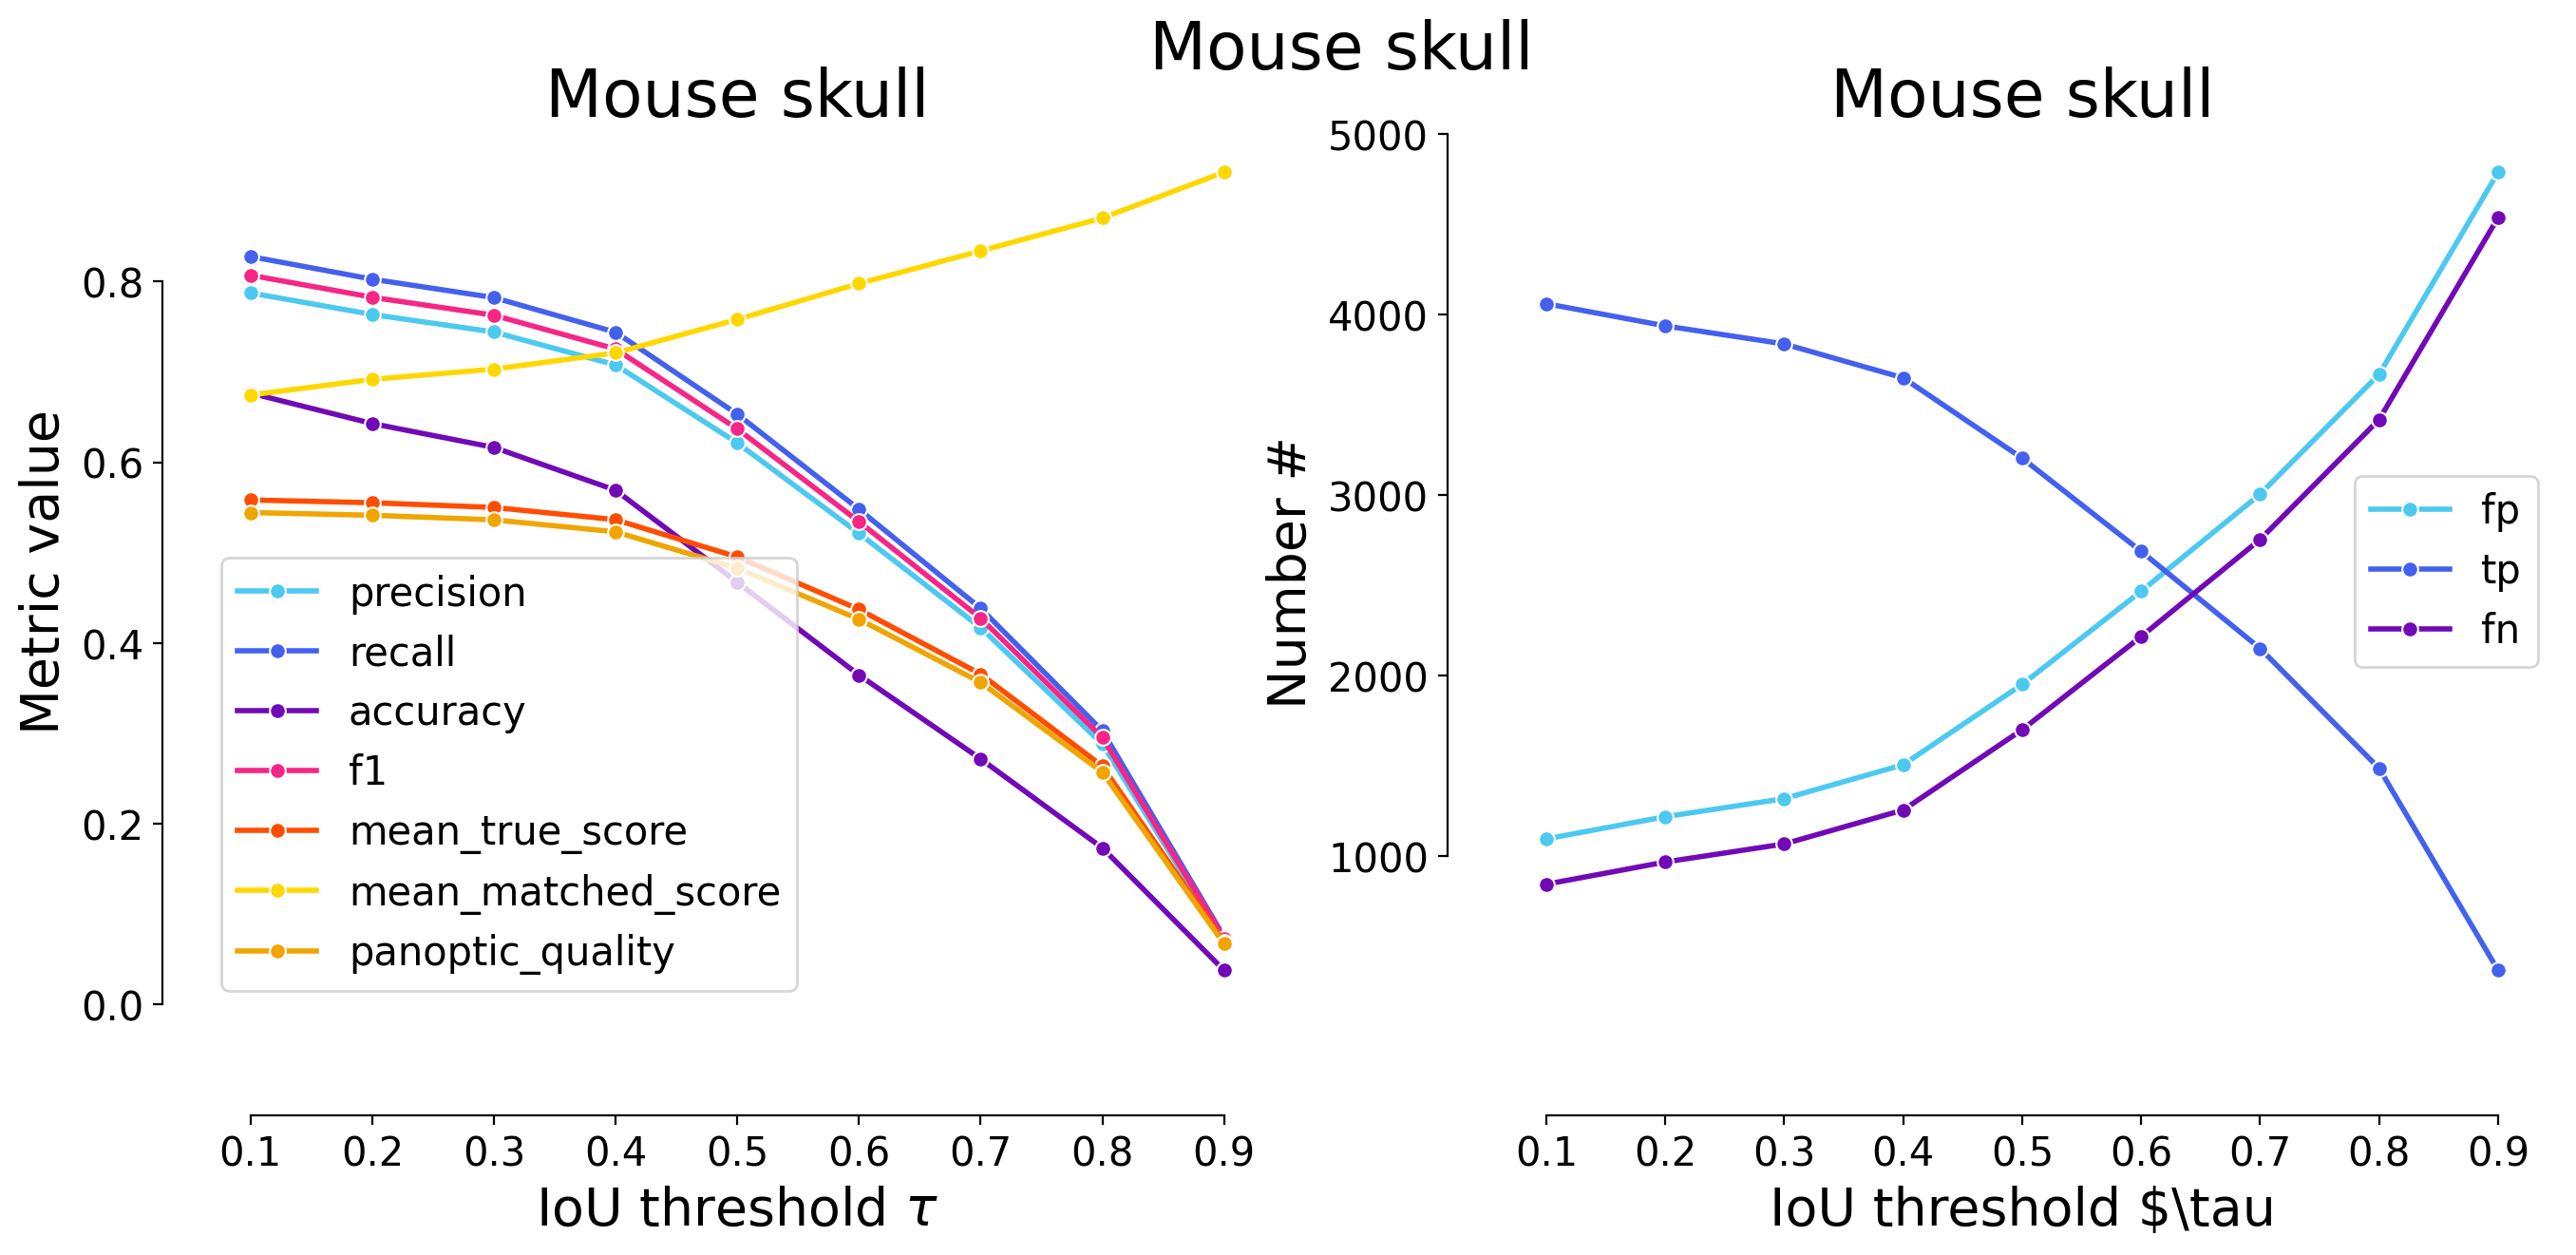

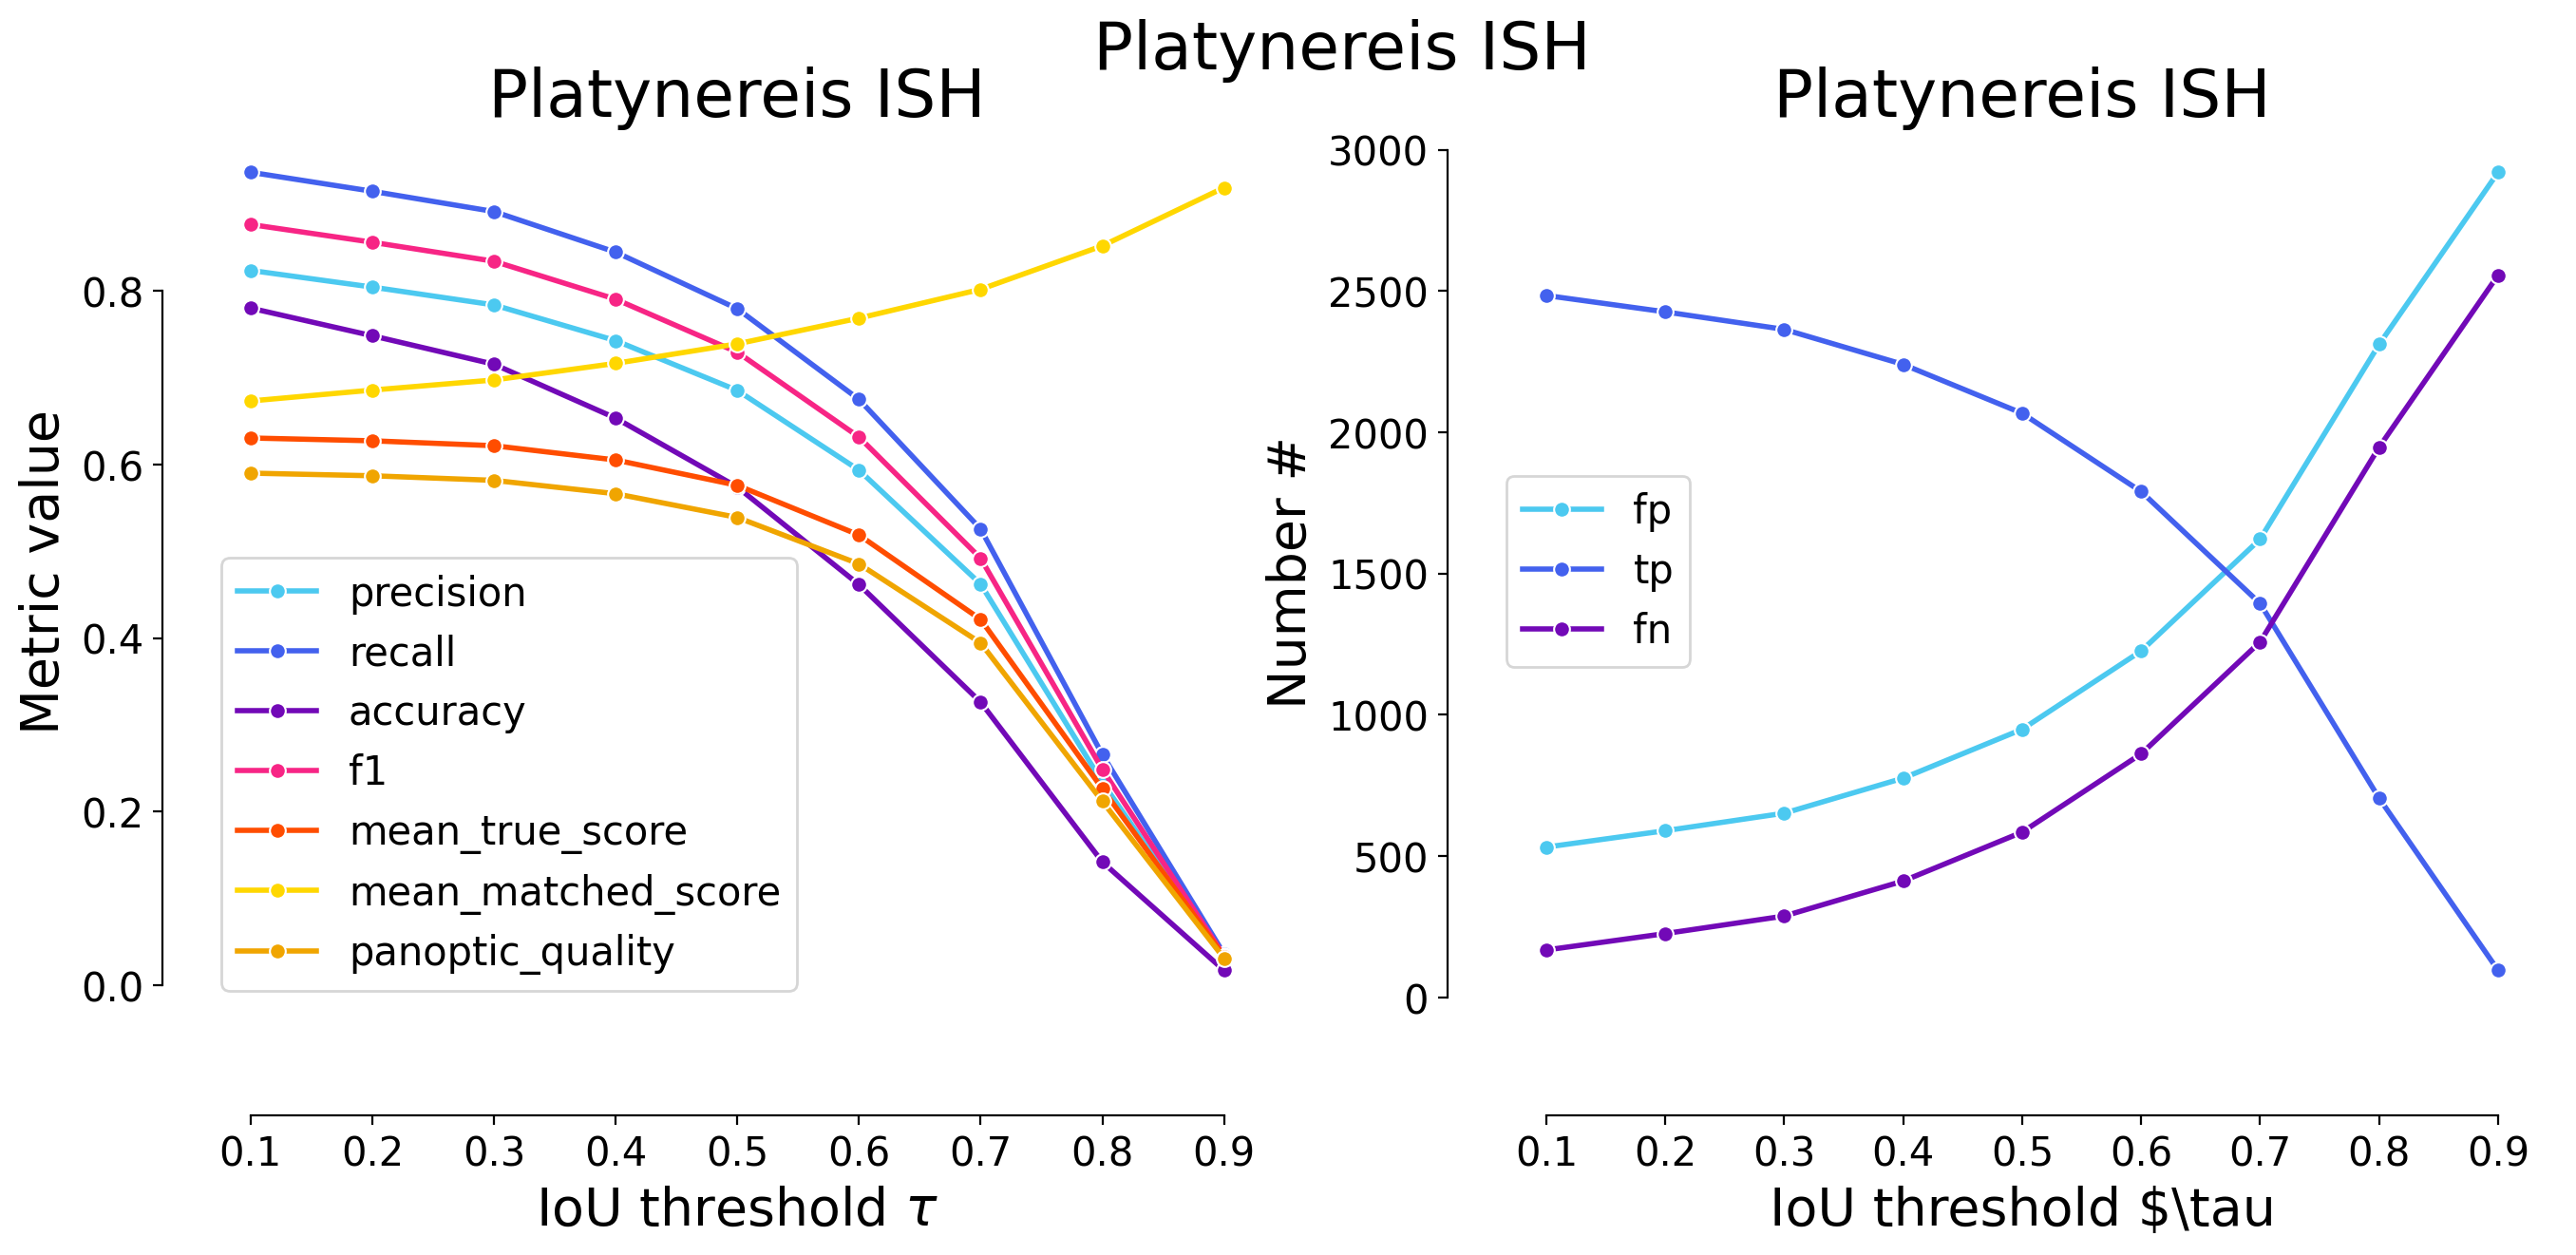

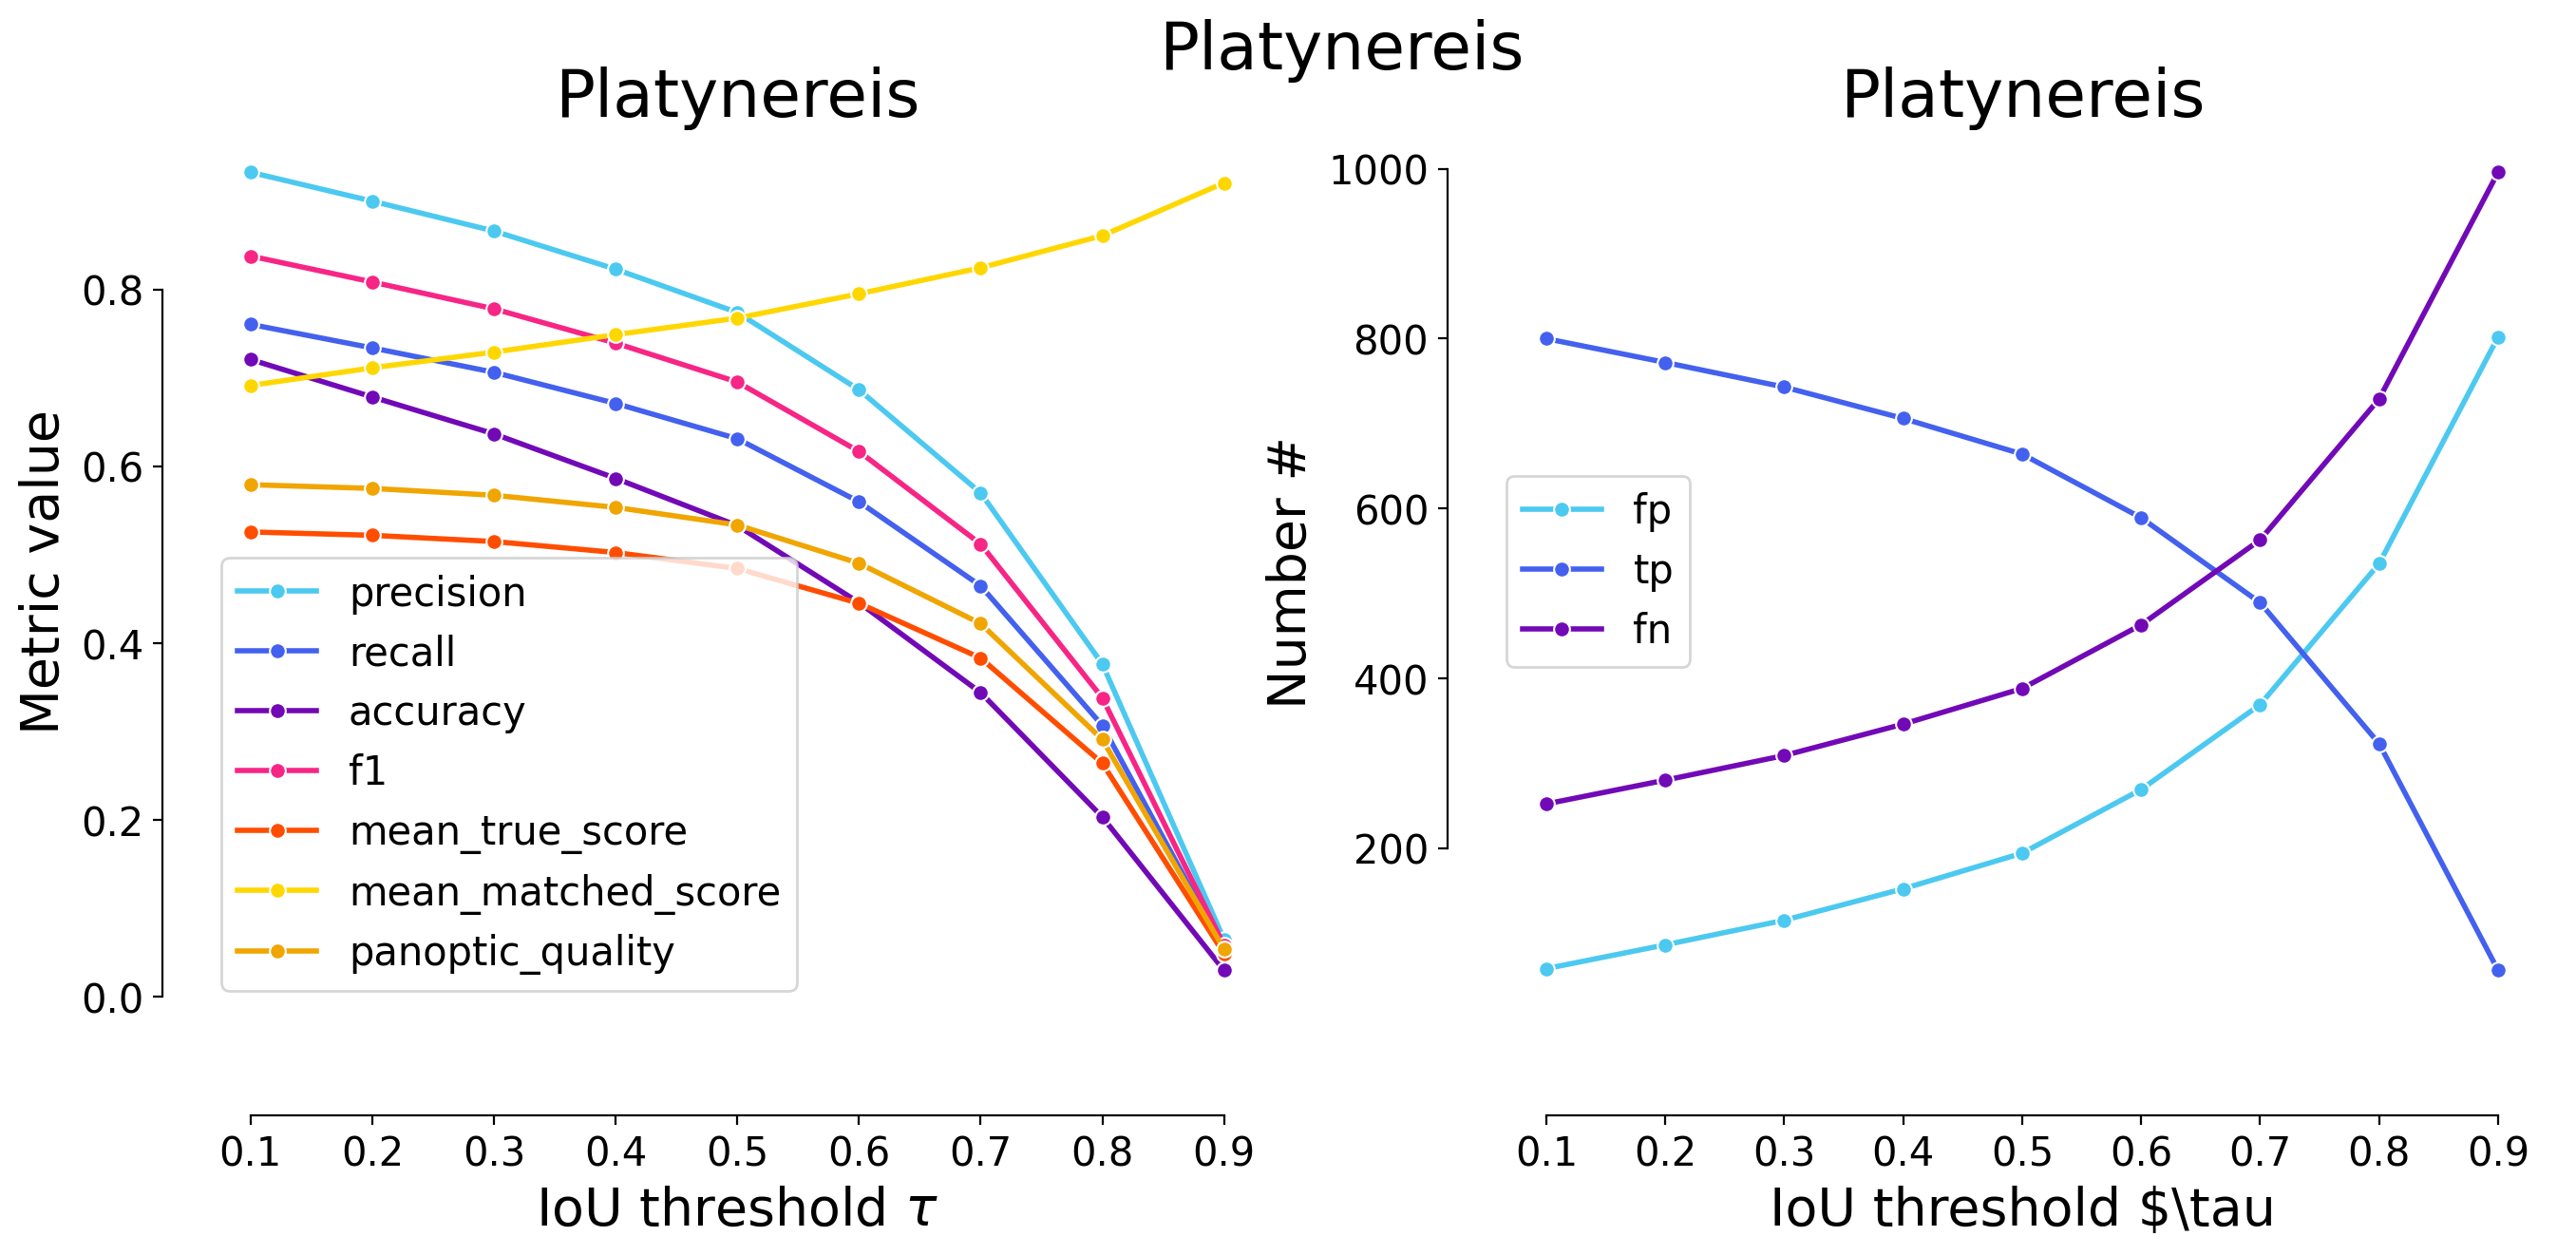

In [21]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


model_stats = []
names_stats = []

for i, p in enumerate(predictions):
    print(f"Validating on {names[i]}")
    stats = [matching_dataset(
        GT_labels[i], 
        p,
        thresh=t, 
        show_progress=False
        ) for t in taus]
    model_stats.append(stats)
    for t in taus:
        names_stats.append(names[i])
    # uncomment for ALL plots : 
    plot_performance(taus, stats, name=names[i])
    print("*"*20)

In [22]:
dfs = [dataset_matching_stats_to_df(s) for s in model_stats]
df = pd.concat(dfs)
df["Dataset"] = names_stats
df

,criterion,fp,tp,fn,precision,recall,accuracy,f1,n_true,n_pred,mean_true_score,mean_matched_score,panoptic_quality,by_image,Dataset
thresh,,,,,,,,,,,,,,,
0.1,iou,1096,4061,845,0.787473,0.827762,0.676608,0.807115,4906,5157,0.558399,0.674588,0.544470,False,Mouse skull
0.2,iou,1219,3938,968,0.763622,0.802691,0.642939,0.782669,4906,5157,0.555335,0.691842,0.541483,False,Mouse skull
0.3,iou,1319,3838,1068,0.744231,0.782307,0.616546,0.762794,4906,5157,0.550126,0.703209,0.536404,False,Mouse skull
0.4,iou,1507,3650,1256,0.707776,0.743987,0.569156,0.725430,4906,5157,0.536541,0.721169,0.523158,False,Mouse skull
0.5,iou,1952,3205,1701,0.621485,0.653282,0.467337,0.636987,4906,5157,0.495302,0.758175,0.482948,False,Mouse skull
0.6,iou,2468,2689,2217,0.521427,0.548104,0.364660,0.534433,4906,5157,0.437325,0.797887,0.426417,False,Mouse skull
0.7,iou,3006,2151,2755,0.417103,0.438443,0.271866,0.427507,4906,5157,0.365661,0.834001,0.356541,False,Mouse skull
0.8,iou,3670,1487,3419,0.288346,0.303098,0.173391,0.295538,4906,5157,0.263805,0.870361,0.257225,False,Mouse skull
0.9,iou,4789,368,4538,0.071359,0.075010,0.037958,0.073139,4906,5157,0.069084,0.920993,0.067361,False,Mouse skull


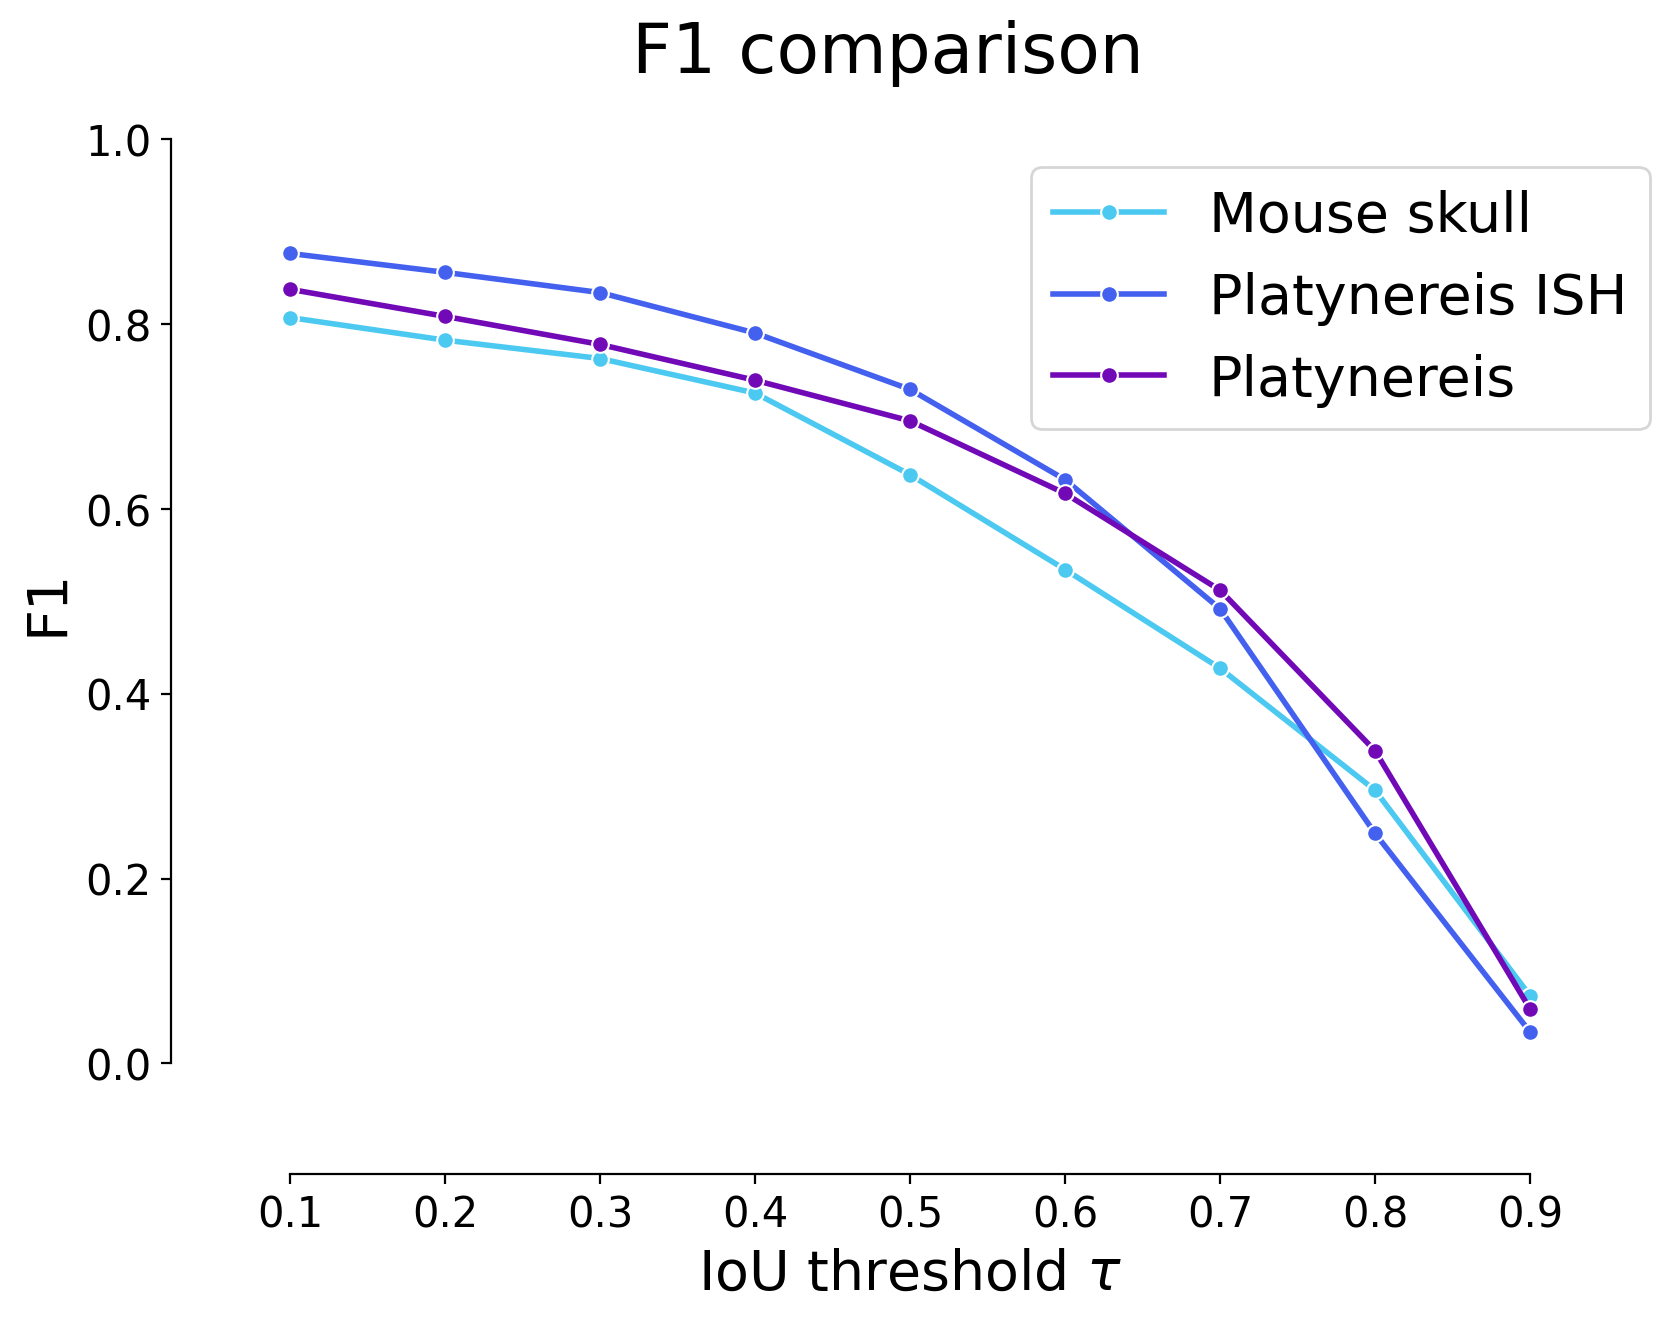

In [23]:
plot_stat_comparison(taus=taus, stats_list=model_stats, model_names=names, metric="IoU", plt_size=(9, 6))
if SAVE_PLOTS_AS_PNG:
    plt.savefig("f1_comparison.png")
if SAVE_PLOTS_AS_SVG:
    plt.savefig("f1_comparison.svg", bbox_inches='tight')

---

## Sanity check : Images only (no WNet)

The aim here is to check that using the WNet does provide a benefit over using Otsu thresholding and Voronoi-based instance segmentation directly on the images.

In [24]:
mouse_skull_image = imread(folders[0] / "X1.tif")
platynereis_ISH_image = imread(folders[1] / "X01_cropped_downsampled.tif") 
platynereis_image = imread(folders[2] / "downsmapled_cropped_dataset_hdf5_100_0.tif")

In [25]:
mouse_skull_instance = np.array(
    cle.voronoi_otsu_labeling(cle.threshold_otsu(mouse_skull_image), outline_sigma=1, spot_sigma=15)
)
platynereis_ISH_instance = np.array(
    cle.voronoi_otsu_labeling(cle.threshold_otsu(platynereis_ISH_image), outline_sigma=0.5, spot_sigma=2)
)
platynereis_instance = np.array(
    cle.voronoi_otsu_labeling(cle.threshold_otsu(platynereis_image), outline_sigma=0.5, spot_sigma=2.75)
)

In [26]:
mouse_skull_instance = np.array(cle.closing_labels(mouse_skull_instance, radius=8))

In [27]:
def remap_image(image, new_min=1, new_max=100):
    min_val = image.min()
    max_val = image.max()
    return (image - min_val) / (max_val - min_val) * (new_max - new_min) + new_min

In [28]:
mouse_skull_remap = remap_image(mouse_skull_image)
mouse_skull_instance = cle.merge_labels_with_border_intensity_within_range(
    image=mouse_skull_remap,
    labels=mouse_skull_instance.astype(np.int32), 
    minimum_intensity=35, 
    maximum_intensity=100
    )
mouse_skull_instance = np.array(mouse_skull_instance)

_generate_touch_mean_intensity_matrix.py (30): generate_touch_mean_intensity_matrix is supposed to work with images of integer type only.
Loss of information is possible when passing non-integer images.
_opencl_execute.py (281): overflow encountered in cast


In [29]:
predictions_images_only = [
    mouse_skull_instance,
    platynereis_ISH_instance,
    platynereis_instance,
]

Validating on Mouse skull
********************
Validating on Platynereis ISH
********************
Validating on Platynereis
********************


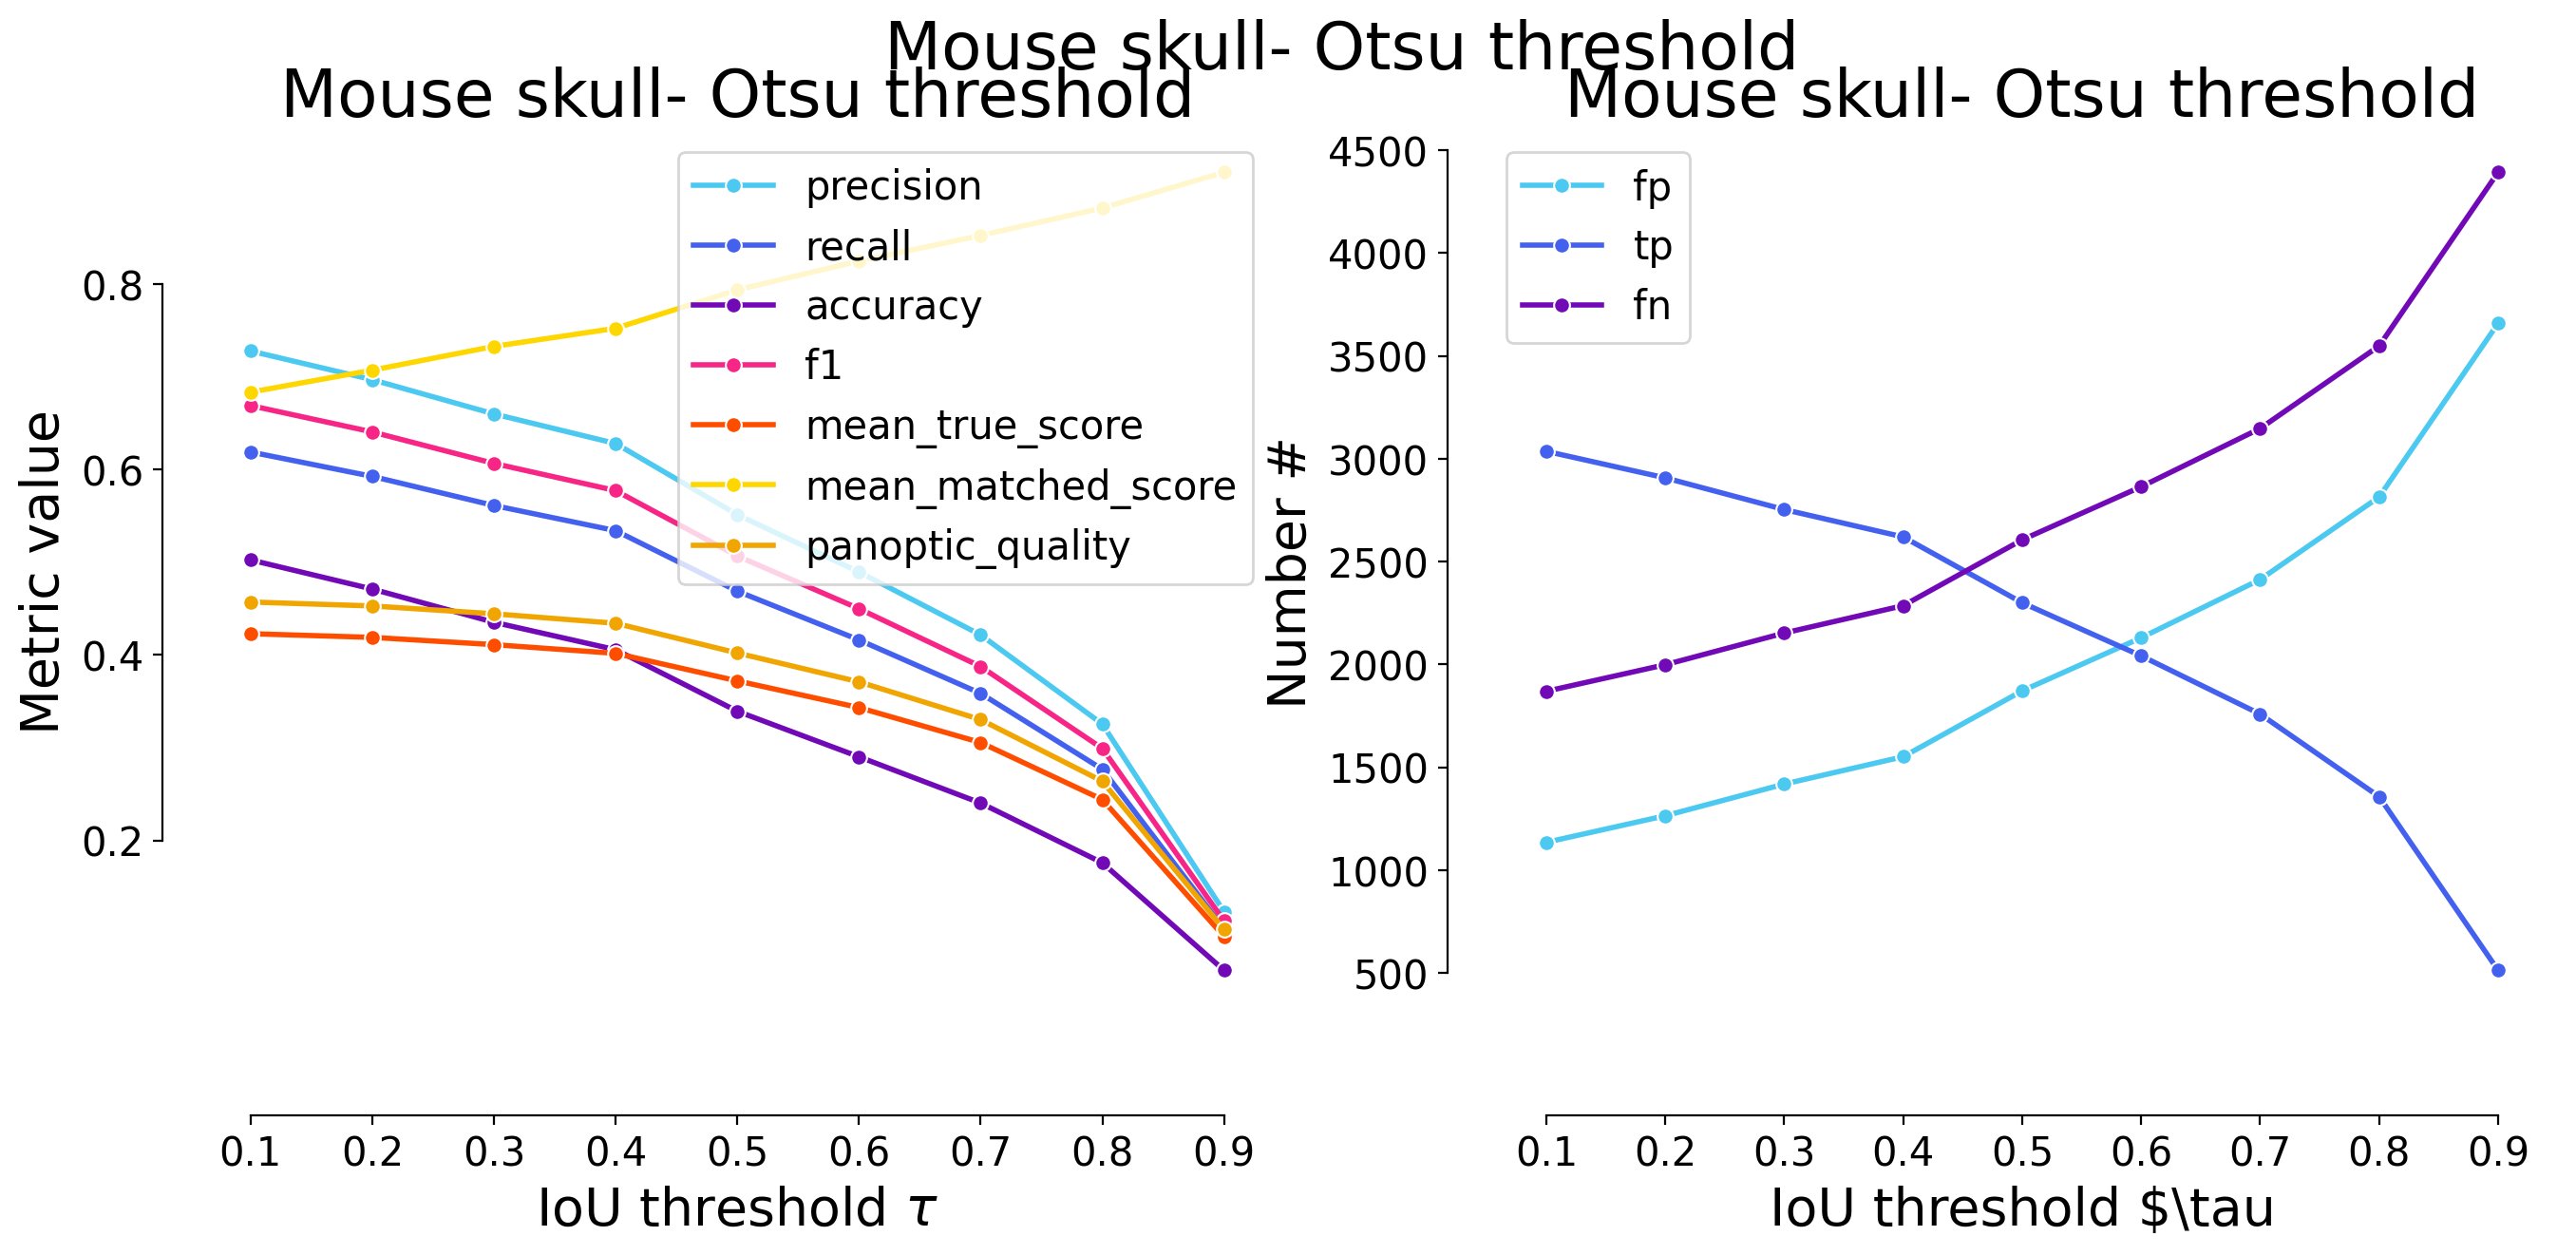

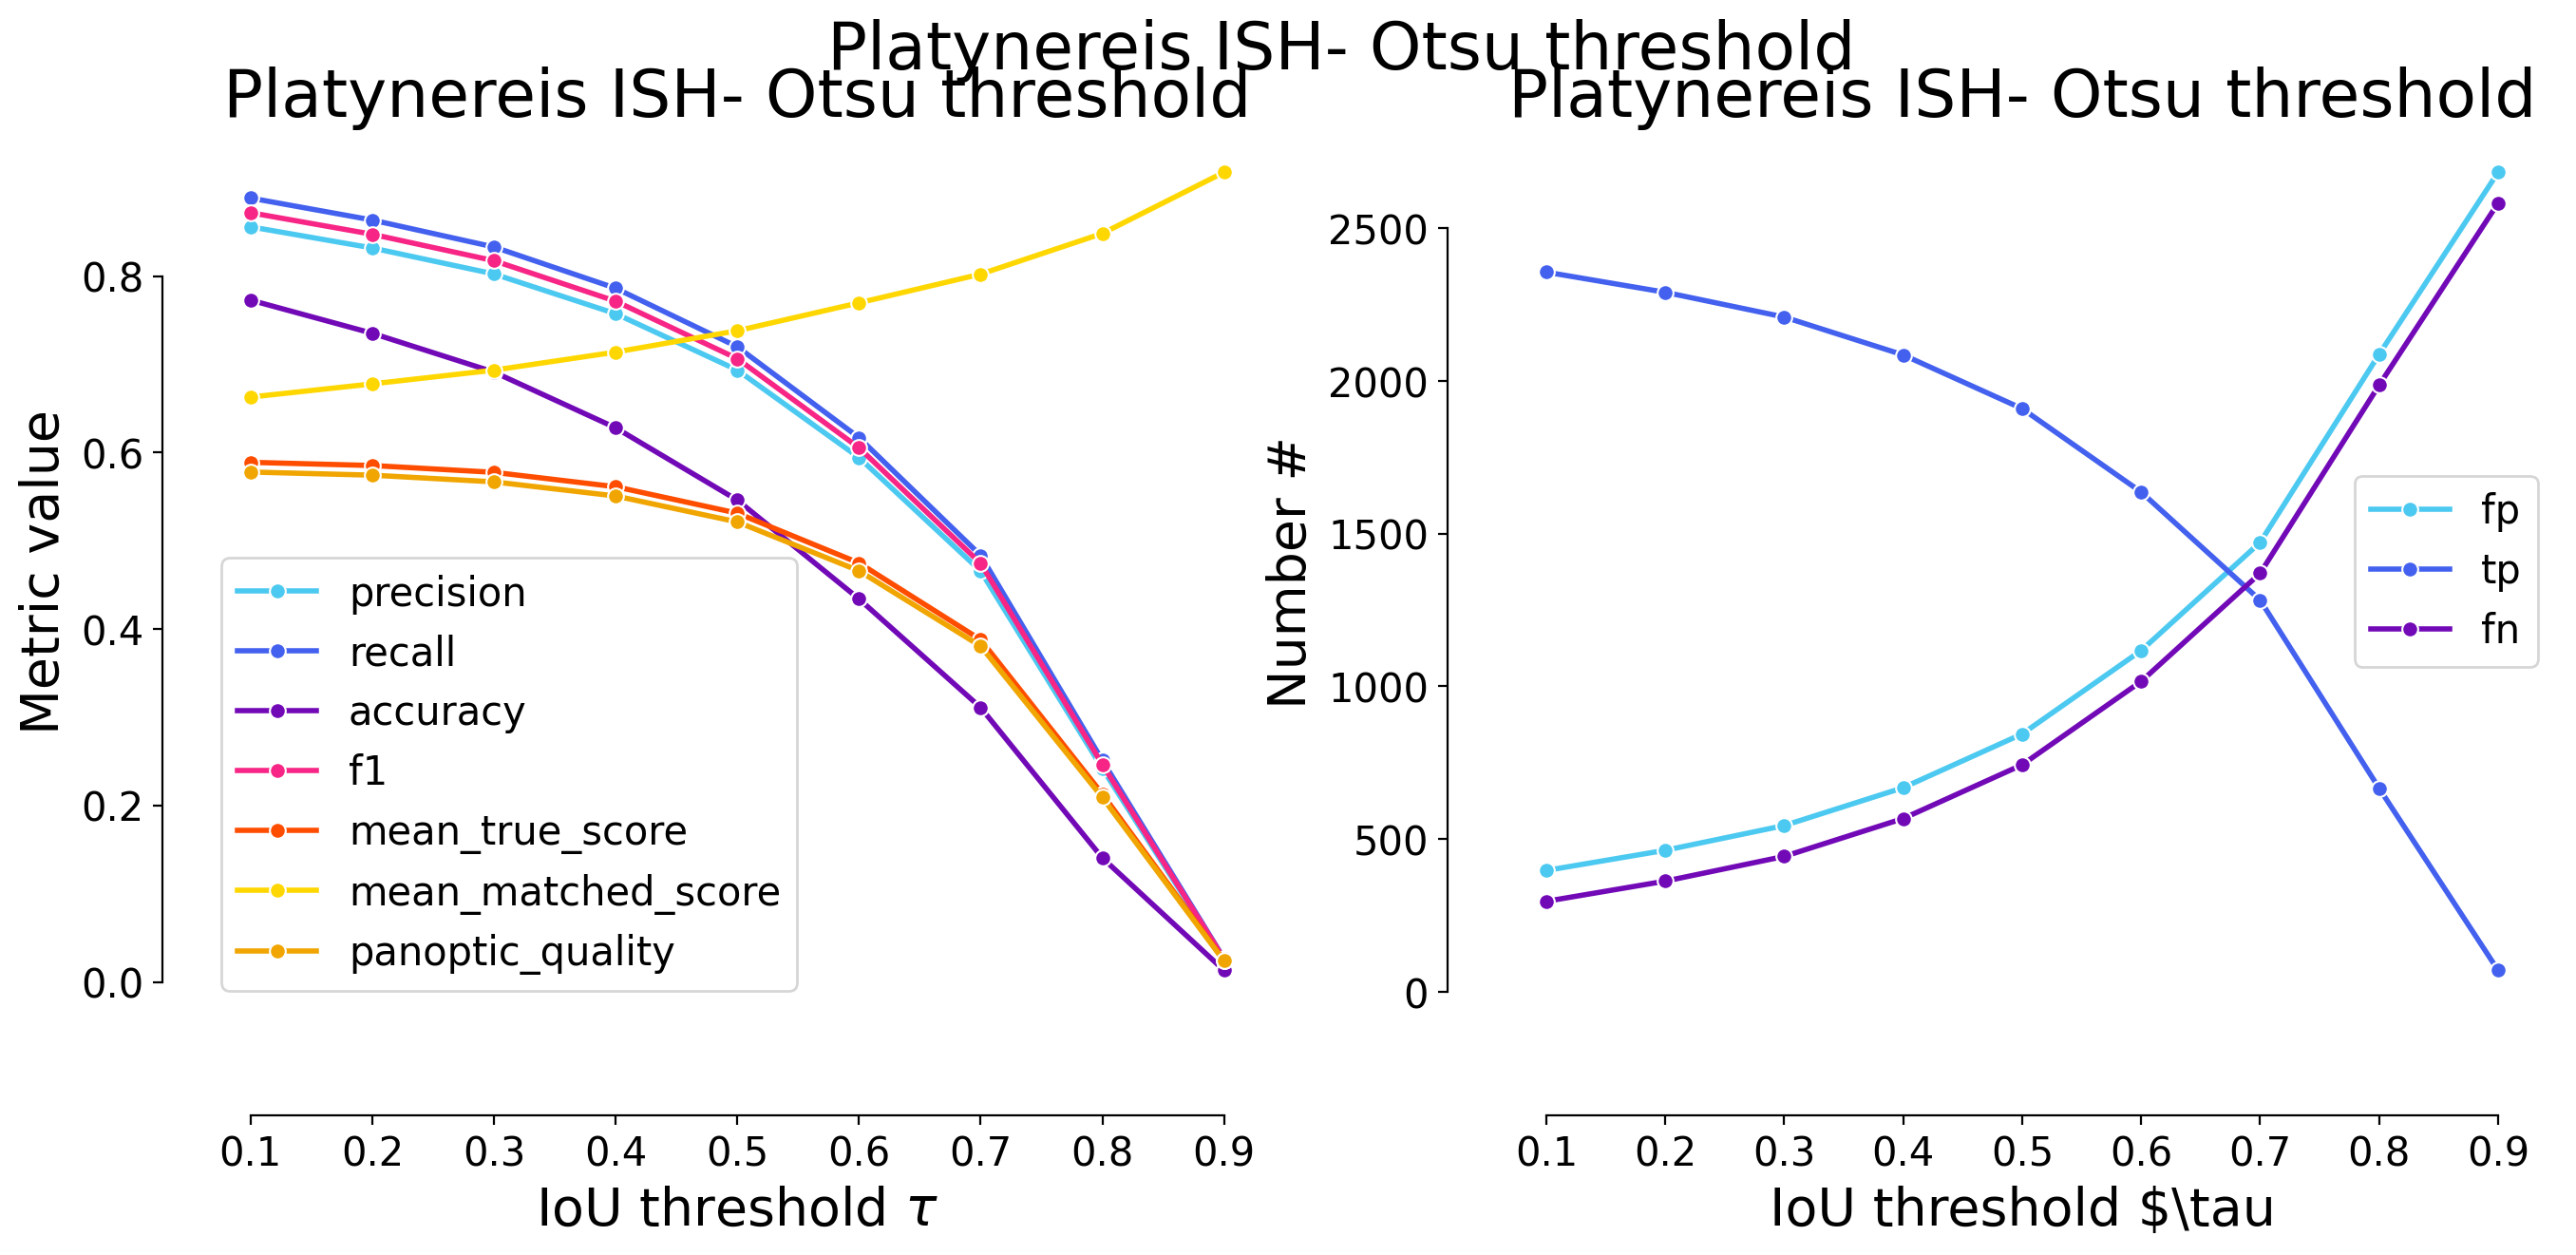

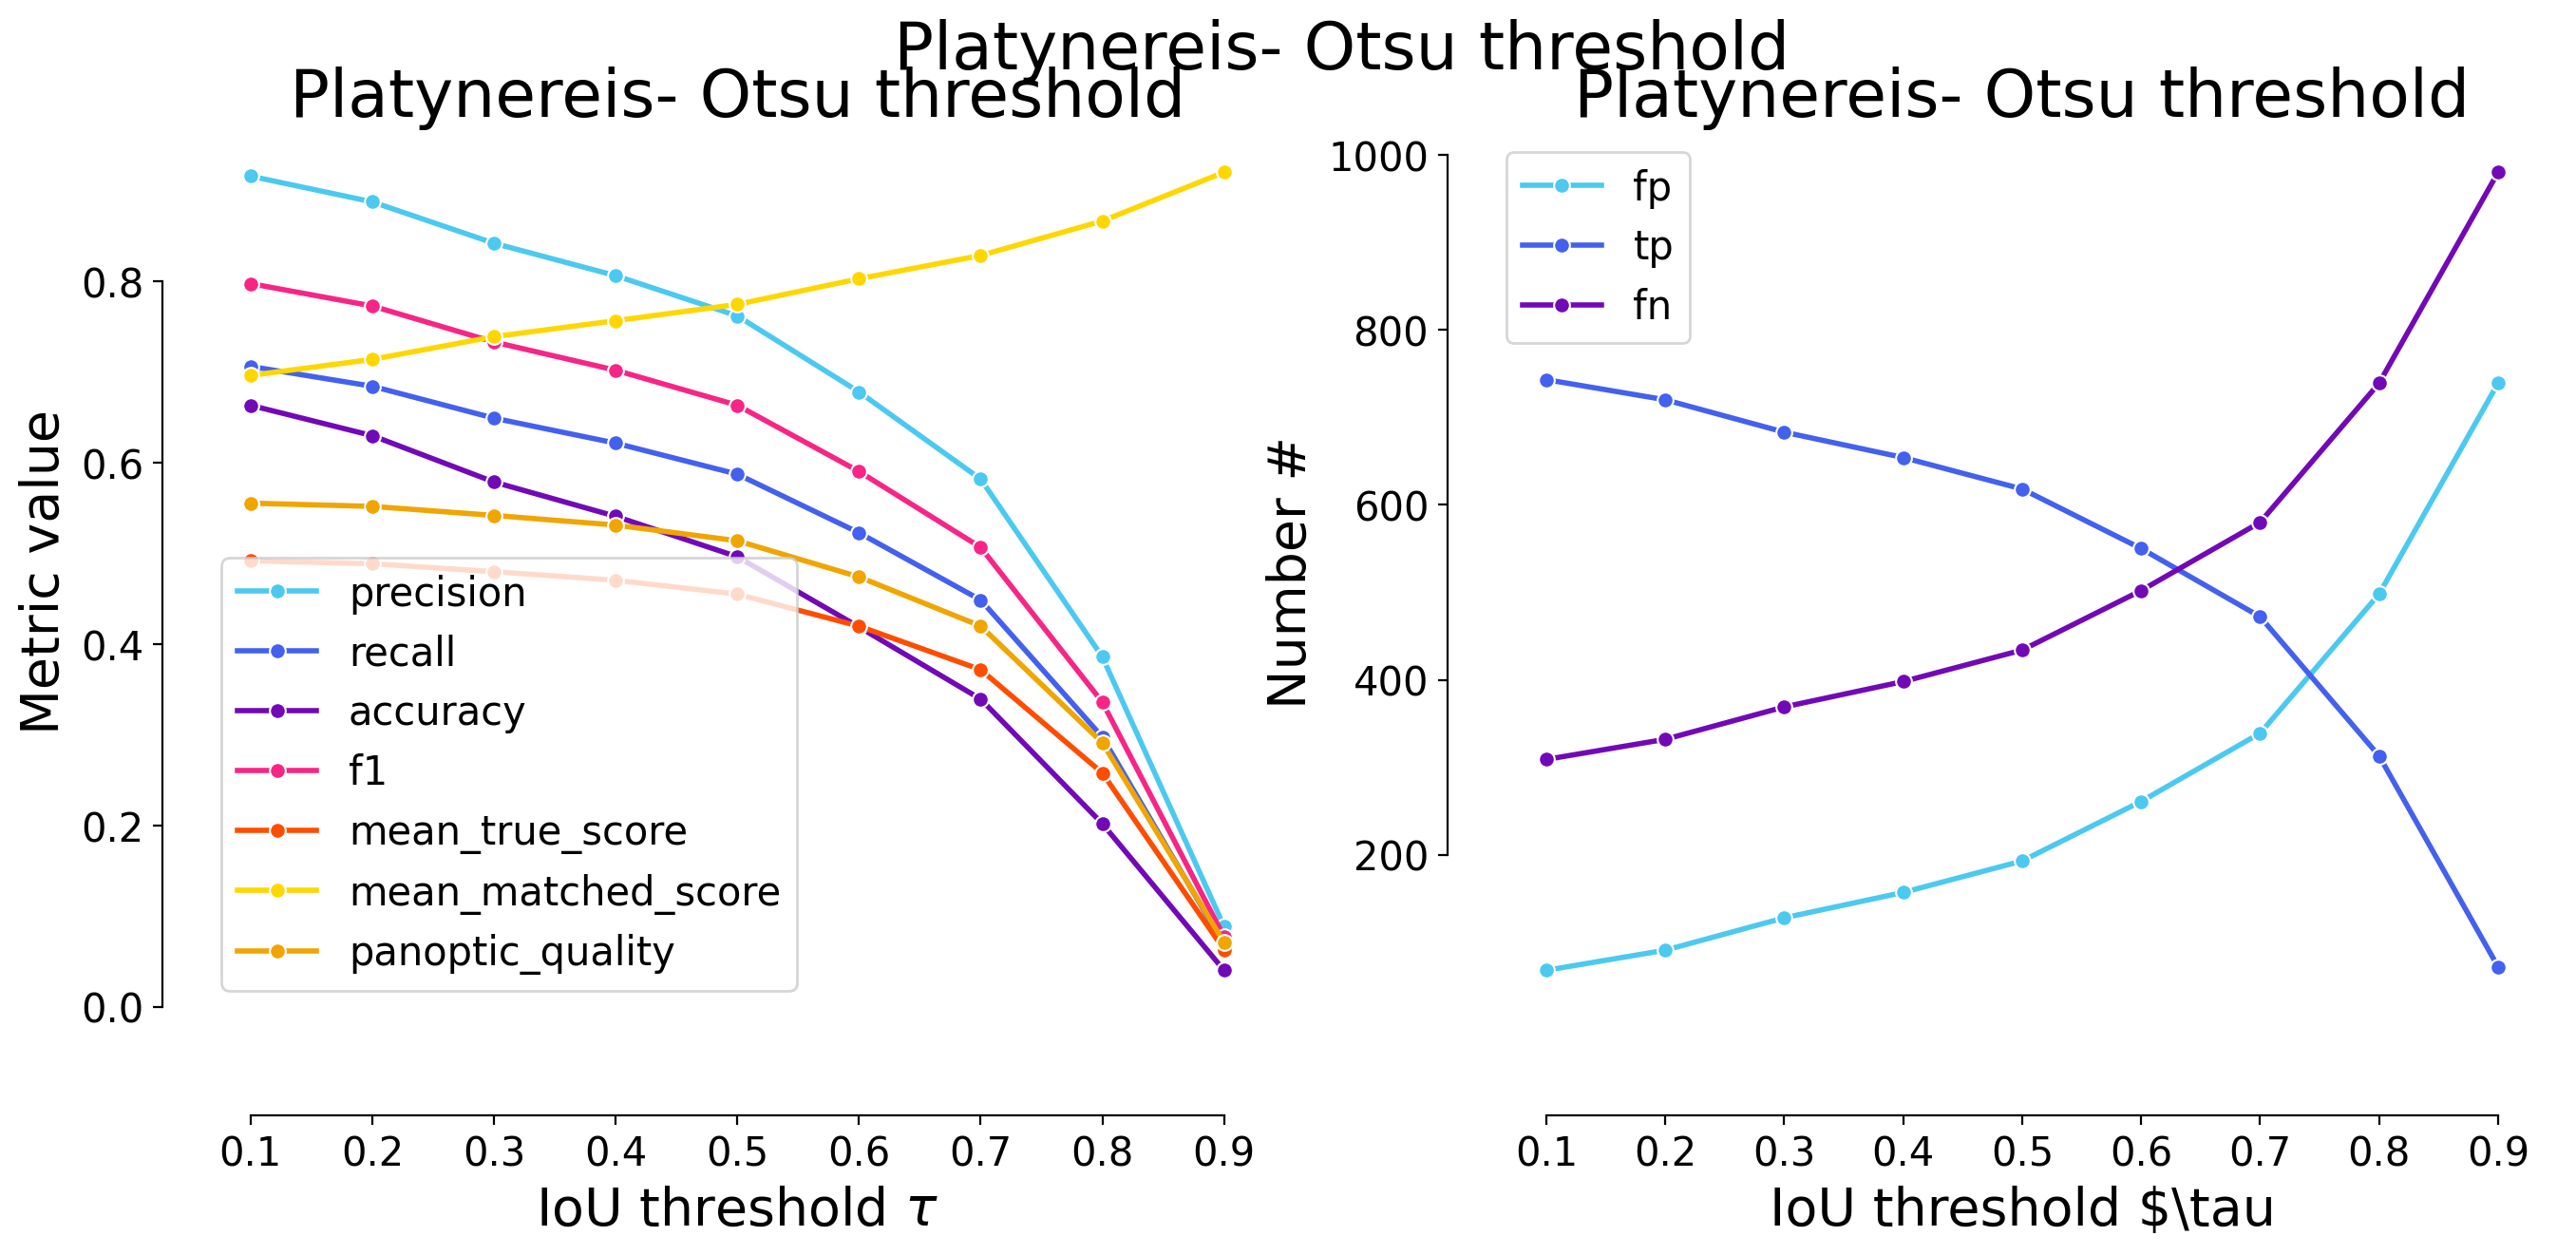

In [30]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


model_stats_images_only = []
names_stats = []

for i, p in enumerate(predictions_images_only):
    print(f"Validating on {names[i]}")
    stats = [matching_dataset(
        GT_labels[i], 
        p,
        thresh=t, 
        show_progress=False
        ) for t in taus]
    model_stats_images_only.append(stats)
    for t in taus:
        names_stats.append(names[i]+"- Otsu threshold") 
    # uncomment for ALL plots : 
    plot_performance(taus, stats, name=names[i]+"- Otsu threshold")
    print("*"*20)

In [31]:
dfs = [dataset_matching_stats_to_df(s) for s in model_stats_images_only]
df_im_only = pd.concat(dfs)
df_im_only["Dataset"] = names_stats
df_all = pd.concat([df, df_im_only])
df_all

,criterion,fp,tp,fn,precision,recall,accuracy,f1,n_true,n_pred,mean_true_score,mean_matched_score,panoptic_quality,by_image,Dataset
thresh,,,,,,,,,,,,,,,
0.1,iou,1096,4061,845,0.787473,0.827762,0.676608,0.807115,4906,5157,0.558399,0.674588,0.544470,False,Mouse skull
0.2,iou,1219,3938,968,0.763622,0.802691,0.642939,0.782669,4906,5157,0.555335,0.691842,0.541483,False,Mouse skull
0.3,iou,1319,3838,1068,0.744231,0.782307,0.616546,0.762794,4906,5157,0.550126,0.703209,0.536404,False,Mouse skull
0.4,iou,1507,3650,1256,0.707776,0.743987,0.569156,0.725430,4906,5157,0.536541,0.721169,0.523158,False,Mouse skull
0.5,iou,1952,3205,1701,0.621485,0.653282,0.467337,0.636987,4906,5157,0.495302,0.758175,0.482948,False,Mouse skull
0.6,iou,2468,2689,2217,0.521427,0.548104,0.364660,0.534433,4906,5157,0.437325,0.797887,0.426417,False,Mouse skull
0.7,iou,3006,2151,2755,0.417103,0.438443,0.271866,0.427507,4906,5157,0.365661,0.834001,0.356541,False,Mouse skull
0.8,iou,3670,1487,3419,0.288346,0.303098,0.173391,0.295538,4906,5157,0.263805,0.870361,0.257225,False,Mouse skull
0.9,iou,4789,368,4538,0.071359,0.075010,0.037958,0.073139,4906,5157,0.069084,0.920993,0.067361,False,Mouse skull


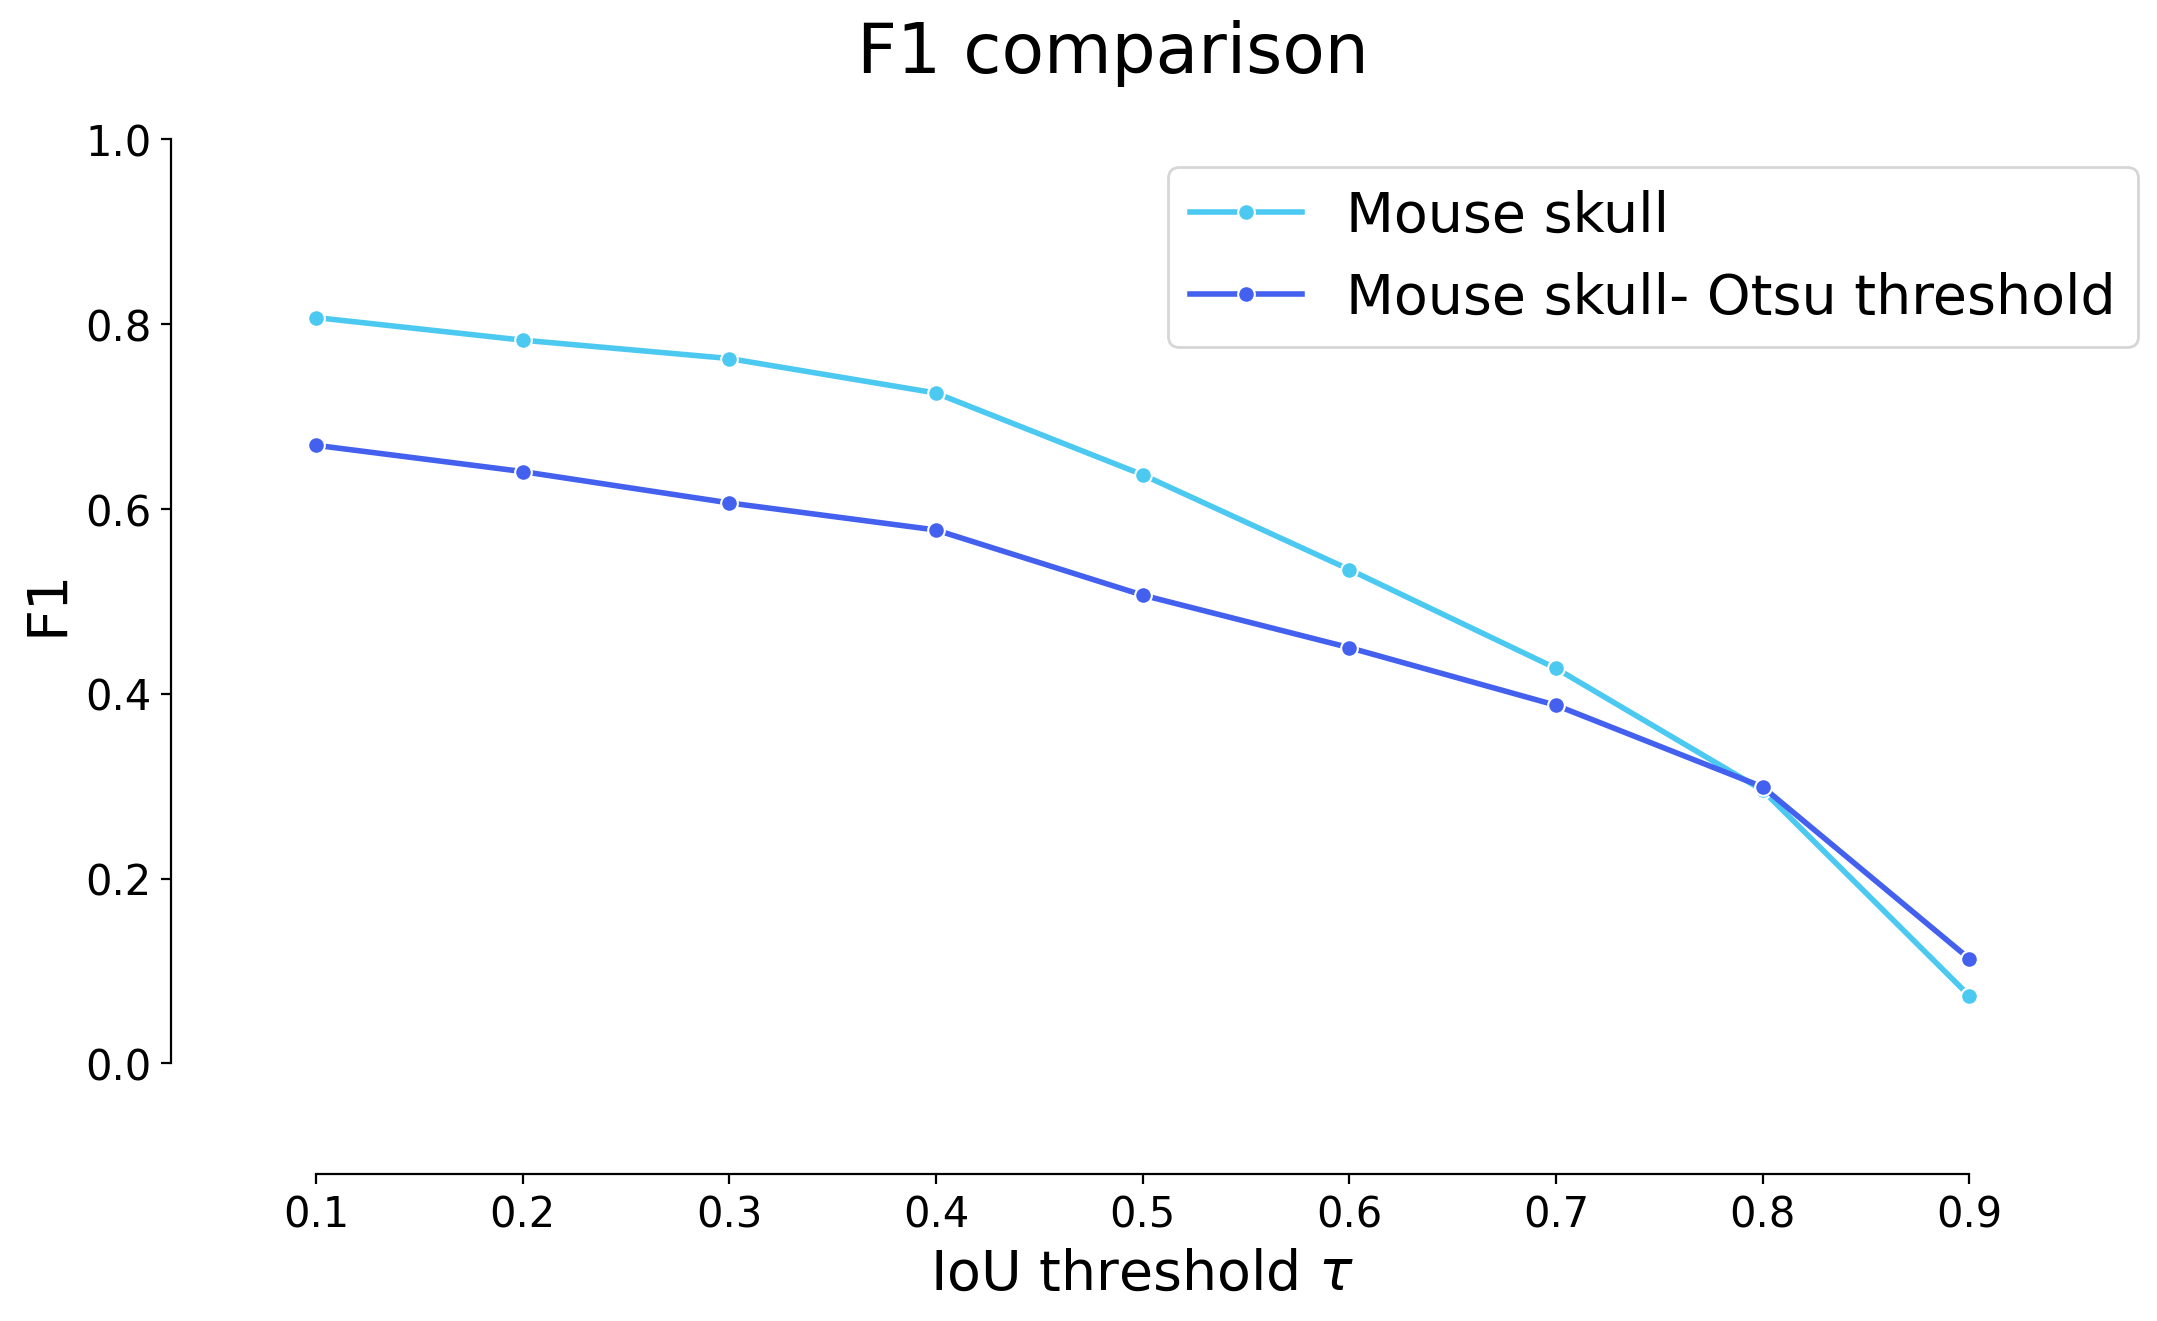

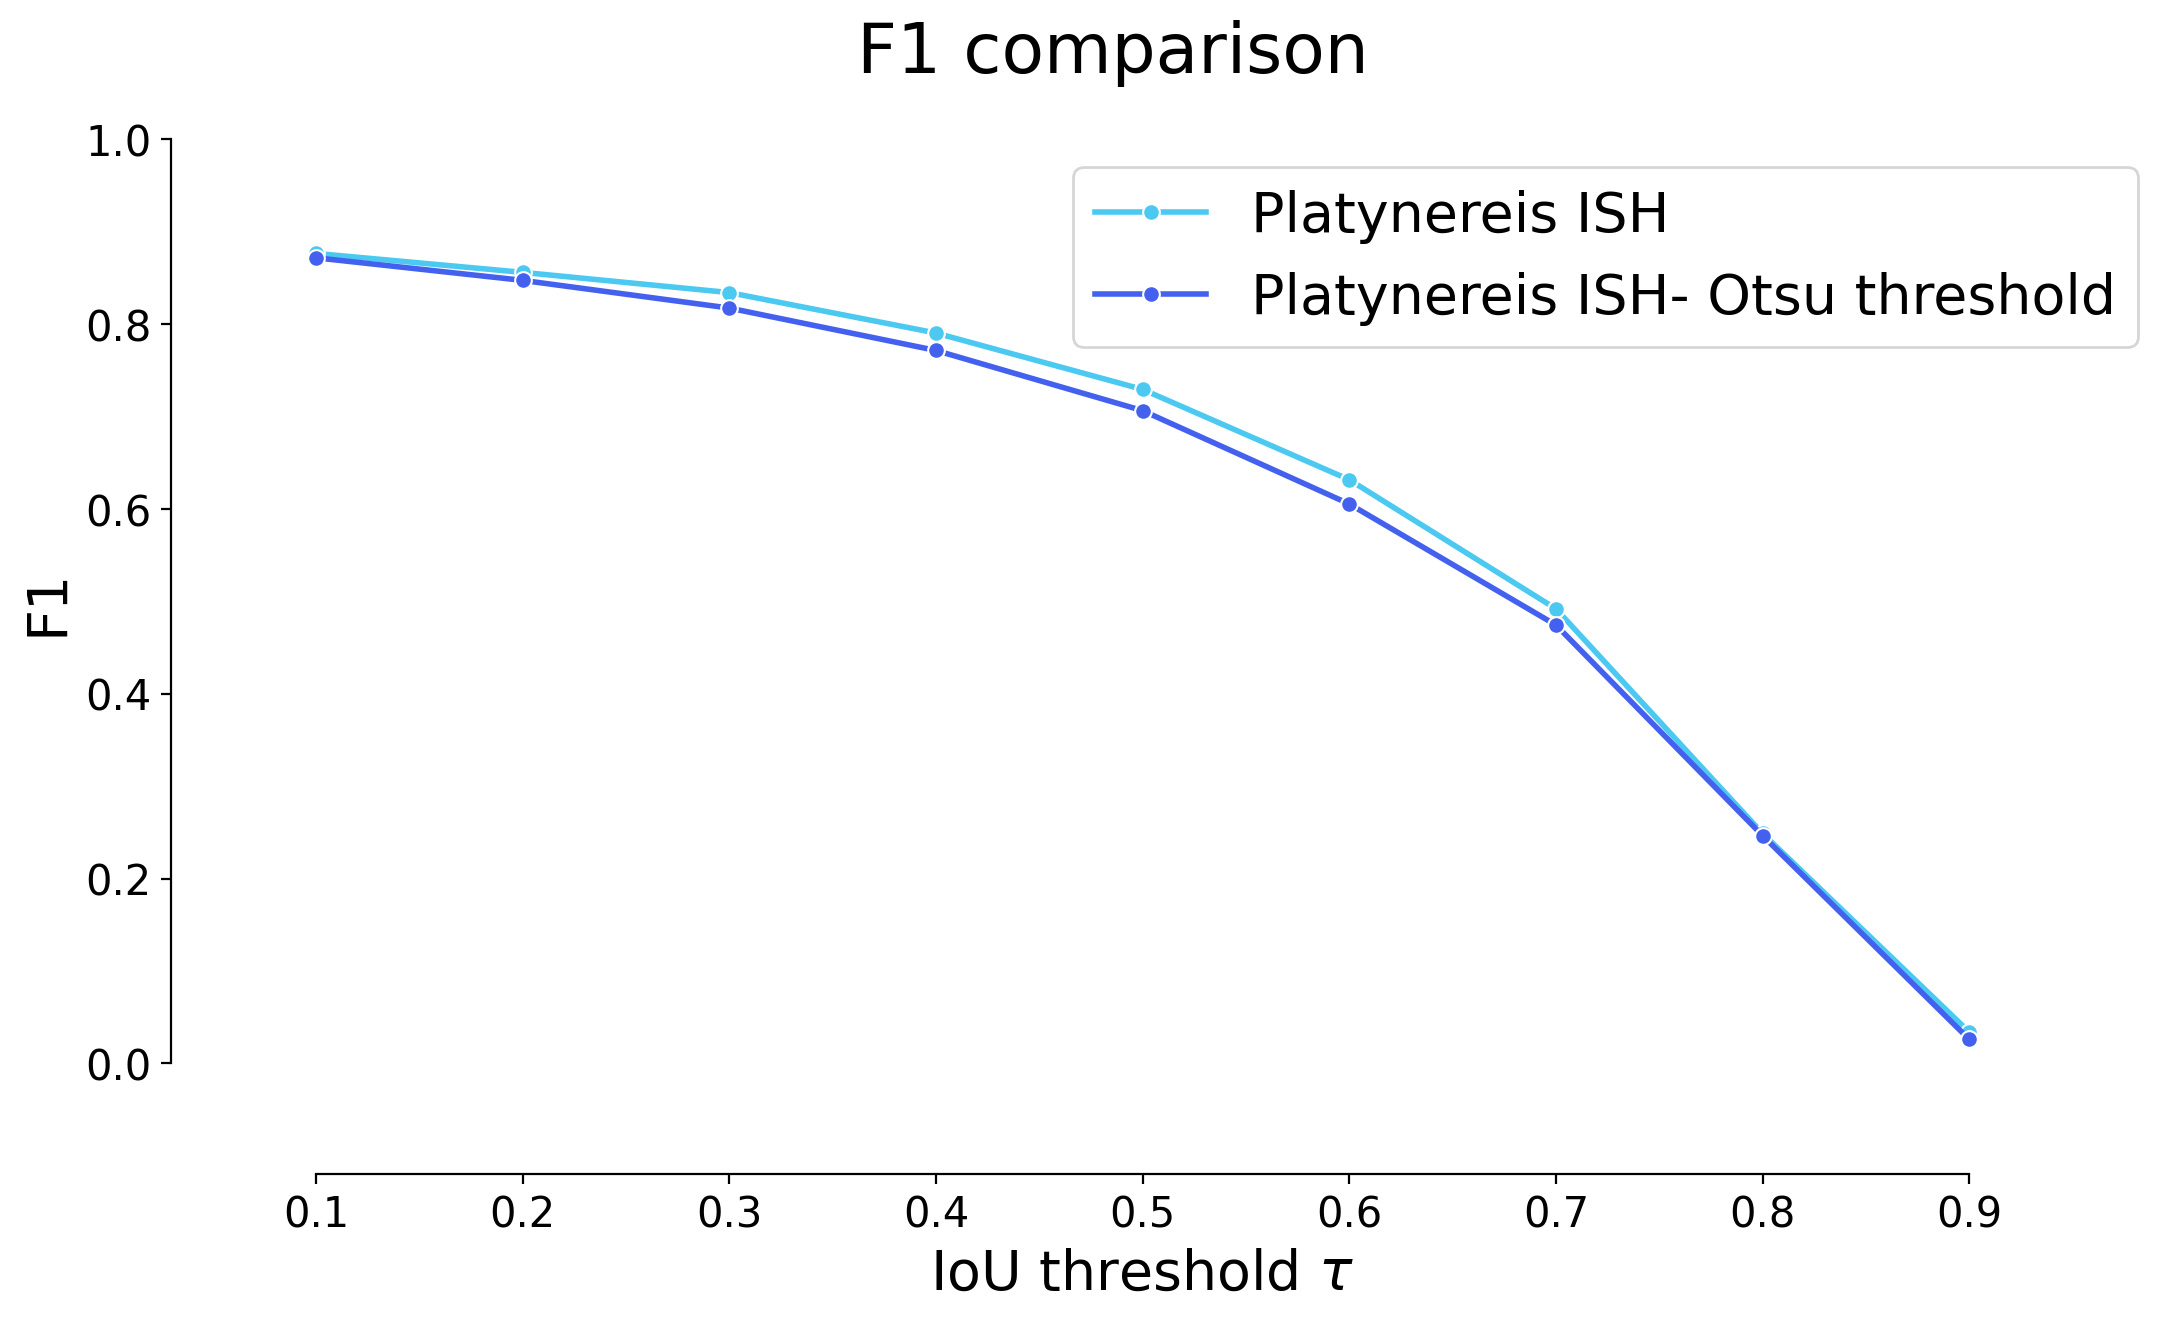

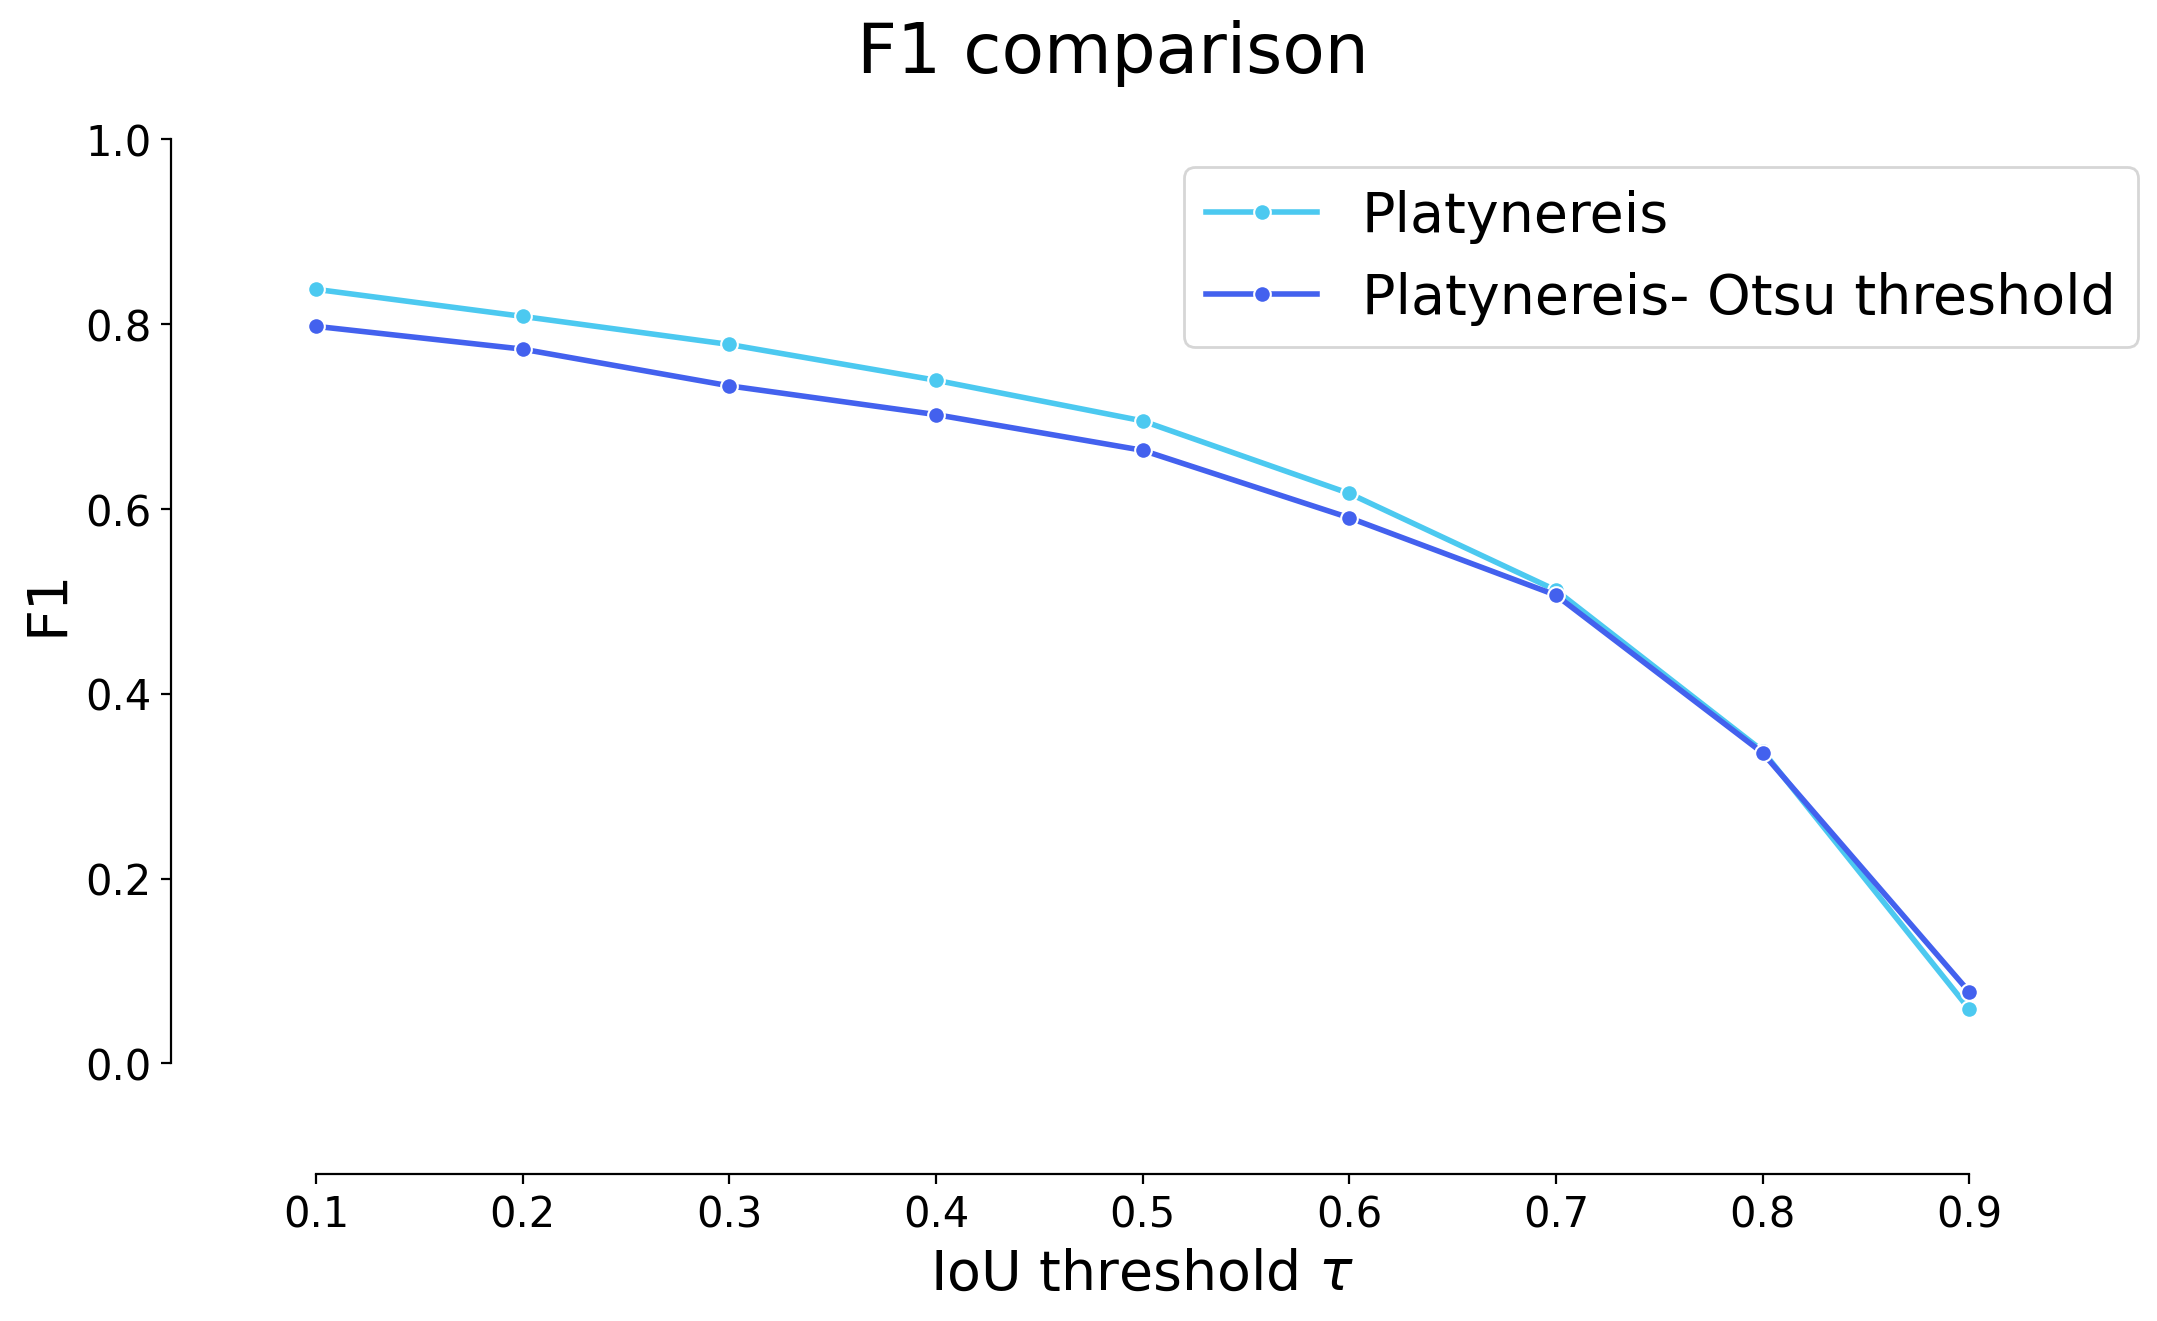

In [34]:
# plot each model vs threshold only pair separately

for i, stats_model, stats_image_only in zip(range(len(model_stats)), model_stats, model_stats_images_only):
    plot_stat_comparison(taus=taus, stats_list=[stats_model, stats_image_only], model_names=[names[i], names[i]+"- Otsu threshold"], metric="IoU")
    if SAVE_PLOTS_AS_PNG:
        plt.savefig(f"{names[i]}_f1_comparison.png")
    if SAVE_PLOTS_AS_SVG:
        plt.savefig(f"{names[i]}_f1_comparison.svg", bbox_inches='tight')
# plot_stat_comparison(taus=taus, stats_list=model_stats+model_stats_images_only, model_names=df_all.Dataset.unique(), metric="IoU")